In [ ]:
# Alexandre Duval
# Master Research Project 
########################## INTERPRETATION METHODS 

#Import libraries
import numpy as np # linear algebra
import pandas as pd # data processing 
import os
import io
import itertools
import warnings
import math  # for missing values 
import matplotlib.pyplot as plt#visualization
from PIL import  Image
%matplotlib inline
import seaborn as sns #visualization
warnings.filterwarnings("ignore")
import plotly.offline as py #visualization
py.init_notebook_mode(connected=True) #visualization
import plotly.graph_objs as go #visualization
import plotly.tools as tls #visualization
import plotly.figure_factory as ff #visualization

from sklearn.preprocessing import LabelEncoder, OneHotEncoder  # encode categorical variables 
from sklearn.preprocessing import StandardScaler  # standardize data
from sklearn.model_selection import train_test_split  # split between train and test split
from xgboost import XGBClassifier  # model 
import xgboost as xgb
from imblearn.over_sampling import SMOTENC  # unbalanced dataset, deals with categorical variables
from sklearn.model_selection import cross_val_score  # assess performance, avoid overfitting 
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report, roc_auc_score,roc_curve,scorer,f1_score, precision_score,recall_score  # performance metrics
import statsmodels.api as sm
from xgboost import plot_tree  # plot Tree XGBoost



# Import dataset 
telcom = pd.read_csv('Telco_customer_churn.csv')
dataset = pd.read_csv('Telco_customer_churn.csv')



############# DATA MANIPULATION 


## Identify missing values 
w=float('nan')
math.isnan(w)
telcom.isna().sum()

# Missing values 
telcom[telcom['TotalCharges']== " "] # 11 missing values for the Total charges column
telcom['TotalCharges'] = telcom["TotalCharges"].replace(" ",np.nan) # replace spaces with null values in TotalCharges column
telcom = telcom[telcom["TotalCharges"].notnull()] # drop these observations 
telcom = telcom.reset_index()[telcom.columns] # reset index 
telcom["TotalCharges"] = telcom["TotalCharges"].astype(float) #convert to float type

#Replace 'No internet service' to 'No' for the following columns. If they don't have internet, they don't have access to these services. 
replace_cols = [ 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection','TechSupport','StreamingTV', 'StreamingMovies']           
for i in replace_cols : 
    telcom[i]  = telcom[i].replace({'No internet service' : 'No'})
    
# Replace 'No phone service' to 'No' for the MultipleLines columns. 
telcom['MultipleLines'] = telcom['MultipleLines'].replace({'No phone service':'No'})
    
# Modify Senior Citizen binary dummy variable. Want Yes or No instead of 0,1; only because other dummies are in this format. Easier to deal with. 
telcom["SeniorCitizen"] = telcom["SeniorCitizen"].replace({1:"Yes",0:"No"})
                                      
#Separating churn and non churn customers. 
churn     = telcom[telcom["Churn"] == "Yes"]
not_churn = telcom[telcom["Churn"] == "No"]

# Customer id col
Id_col     = ['customerID']
# Target columns
target_col = ["Churn"]
# Categorical columns
categorical_features = [0,1,2,3,5,6,7,8,9,10,11,12,13,16,17,18,19,20,21,22,23,24,25]
cat_cols   = telcom.nunique()[telcom.nunique() < 6].keys().tolist()
cat_cols   = [x for x in cat_cols if x not in target_col]
#numerical columns
num_cols   = [x for x in telcom.columns if x not in cat_cols + target_col + Id_col]
#Binary columns with 2 values
bin_cols   = telcom.nunique()[telcom.nunique() == 2].keys().tolist()
#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]




################ Feature engineering part


# Label encoding for Binary columns
le = LabelEncoder()
for i in bin_cols :
    telcom[i] = le.fit_transform(telcom[i])
  
    
# Encode categorical variables. 
telcom = pd.get_dummies(data = telcom,columns = multi_cols )
# No need to delete some dummies to avoid the dummy variable trap, Python handles it. 


# Define dependent and independent variables 
X = telcom.iloc[:, 1: 32]  # delete customer ID from X because won't use it to predict churn. 
X = X.drop(['Churn'], axis = 1) # create dataframe with only independent variables. 
X = X.astype(float)   # keep a dataframe but where all columns are floats. 
Z = X.values  # Save X as an array under the name Z
y = telcom['Churn'].values   # dependent variables, as array. 
features = [i for i in telcom.columns if i not in Id_col + target_col] # Store the name of all variables. 


# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(Z, y, test_size = 0.2, random_state=44)



# Implement SMOTE 
sm = SMOTENC(random_state=40, categorical_features=categorical_features)
X_smote, y_smote = sm.fit_resample(X_train, y_train)

# Train the model on the resampled training dataset. No more unbalanced classes. 
X_train = X_smote
y_train = y_smote





####### MODEL IMPLEMENTATION


# Fitting tuned XGBoost to the Training set
classifier = XGBClassifier( n_estimators=150, learning_rate=0.15, max_depth=3, min_child_weight=0.6,
                            colsample_bytree=1, subsample=1, reg_alpha=0, gamma=0,
                            booster='gbtree', objective='binary:logistic') 
classifier.fit(X_train, y_train)


# Predicting the Test set and Training set results. Also store predicted probabilities used to classify. 
y_pred = classifier.predict(X_test)
y_pred2 = classifier.predict(X_train)
y_proba = classifier.predict_proba(X_test)   # illustrates confidence about predictions. Useful for interpretations. 
y_proba2 = classifier.predict_proba(X_train)  # for ICE,PDP
y_proba3 = y_proba2[:,1]  # only proba of churners 
#y_proba4 = pd.DataFrame(y_proba3)


# Need a dataframe as input. 
X_train2 = pd.DataFrame(X_train, columns = features)
X_test2 = pd.DataFrame(X_test, columns = features)
y_test2 = pd.DataFrame(y_test, columns = ['churn'])







################## INTERPRETABILITY PART  




### Main manipulations that need to be done to implement correctly future interpretation methods 


# Feature_names are not kept when fitting XGBoost to the data. We need to proceed to a special manipulation. This will be useful for another feature_importance graph and XGBoost tree plots. 
# Use Dmatrix and xgb.train() to get true feature names in XGBClassifier. Actually, can't add feature names for classification with xgboost so we do it for regression, meaning the redicted probability of churn
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dtest = xgb.DMatrix(X_test, label=y_train, feature_names=features)
xgb_params = {'n_estimators':150, 'learning_rate':0.15, 'max_depth':3, 'min_child_weight':1, 'colsample_bytree':1, 'subsample':1, 'reg_alpha':0, 'gamma':0, 'booster':'gbtree', 'objective':'binary:logistic'}
model = xgb.train(xgb_params, dtrain) 
model_ypred = model.predict(dtest) 


# For ICE & PDP, we need a unique column with churn probabilities of customers instead of original classification. 
# So we create an XGBoost Regressor similarly to the XGBClassifier (same tuning, SMOTE, RFE, split train/test...)
# The results obtained are identical to the 'predict_proba' function of the XGBClassifier for churn = 1, which is exactly what we wanted. 
regressor = xgb.XGBRegressor ( n_estimators=150, learning_rate=0.15, max_depth=3, min_child_weight=1,
                            colsample_bytree=1, subsample=1, reg_alpha=0, gamma=0,
                            booster='gbtree', objective='binary:logistic')
regressor.fit(X_train, y_train)
y2_pred = regressor.predict(X_test)
y2_pred2 = regressor.predict(X_train)  # same as proba_3 (see XGBClassifier above)



# Finally, for a piece of the Partial Dependence Plots analysis, I need a Base Gradient Boosting method (GBM) to make 'PDPbox' work due to Python's current limitations. 
from sklearn.ensemble import GradientBoostingClassifier
model2 = GradientBoostingClassifier(n_estimators=150, max_depth=3,learning_rate=0.1, loss='deviance',random_state=1)
model2.fit(X_train, y_train)




f0 gender
f1 SeniorCitizen
f2 Partner
f3 Dependents
f4 tenure
f5 PhoneService
f6 MultipleLines
f7 OnlineSecurity
f8 OnlineBackup
f9 DeviceProtection
f10 TechSupport
f11 StreamingTV
f12 StreamingMovies
f13 PaperlessBilling
f14 MonthlyCharges
f15 TotalCharges
f16 InternetService_DSL
f17 InternetService_Fiber optic
f18 InternetService_No
f19 Contract_Month-to-month
f20 Contract_One year
f21 Contract_Two year
f22 PaymentMethod_Bank transfer (automatic)
f23 PaymentMethod_Credit card (automatic)
f24 PaymentMethod_Electronic check
f25 PaymentMethod_Mailed check


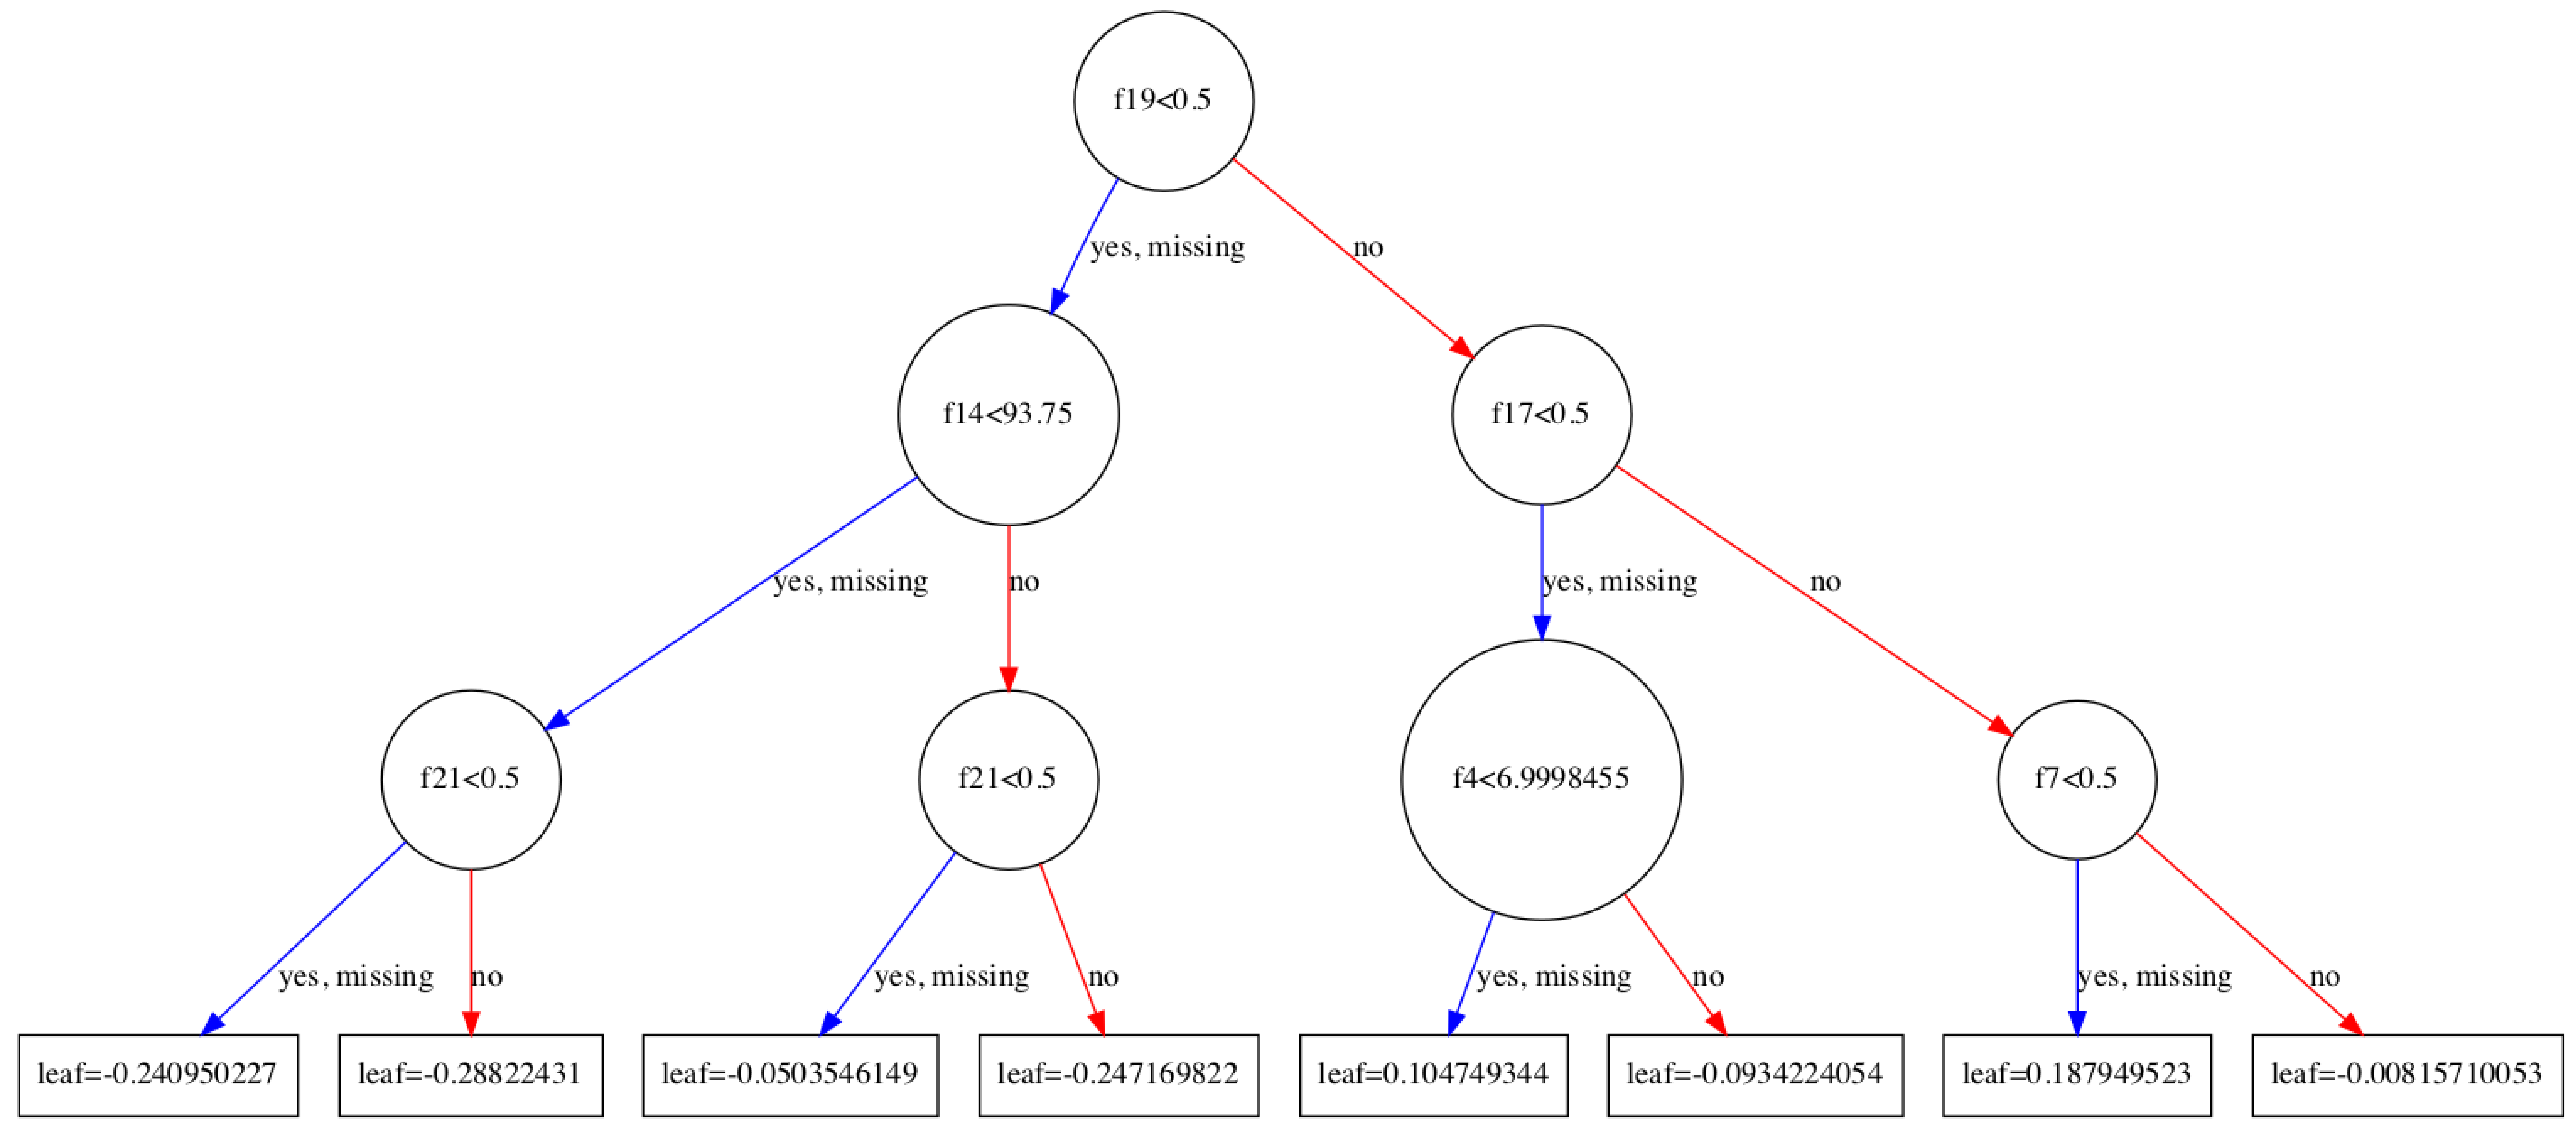

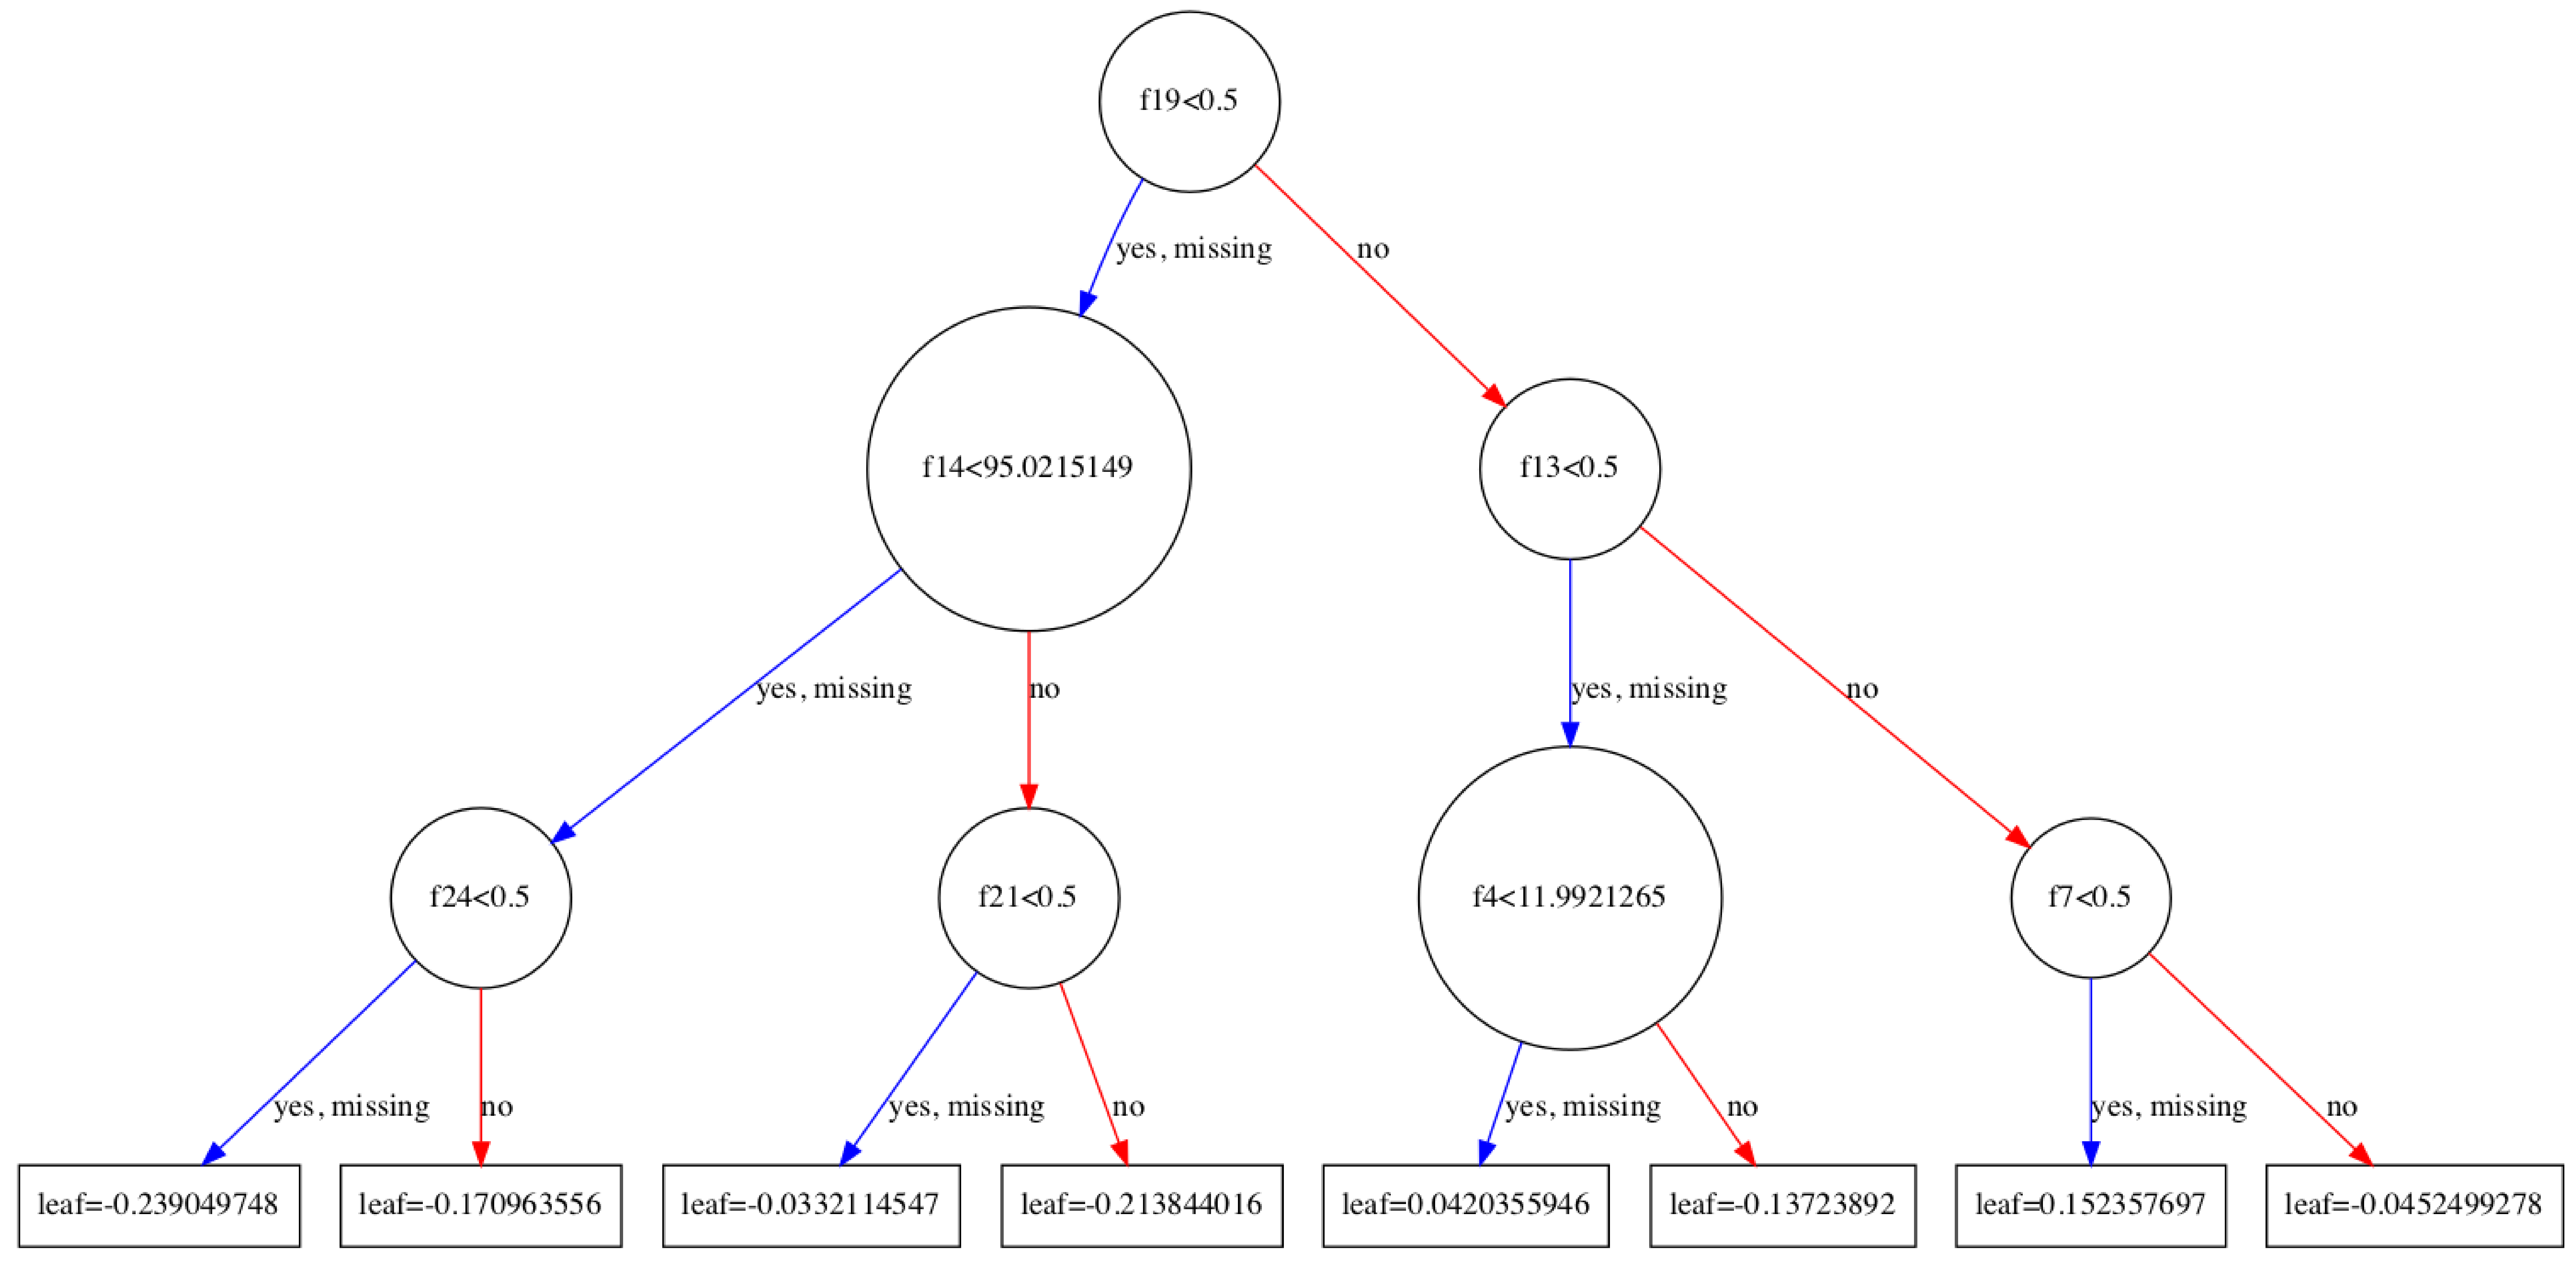

In [2]:


########## Feature contribution 


### Plot trees of XGBoost 


# Feature names are too long so we take the following correspondence in the tree plots. 
dtrain_bis = xgb.DMatrix(X_train, label=y_train)
for i in range(0, len(features)): 
    print dtrain_bis.feature_names[i], features[i]


# Plot the first tree used by XGBoost. (It is built on the training set) 
plot_tree(classifier, num_trees=0)
fig = plt.gcf()
fig.set_size_inches(150, 100)
#fig.savefig('tree.png')
# Features used are Contract_Month-to-month / InternetService_Fiber optic, MonthlyCharges / Contract_Two year (x2), tenure, OnlineSecurity

# Compute the probability of churn for a single leaf of this particulartree. It involves taking the sigmoid function of the leaf output. 
1/(1+np.exp(-1* 0.187949)) # 0.49796073617491465


# Plot the second tree used by XGBoost. 
plot_tree(classifier, num_trees=1)
fig = plt.gcf()
fig.set_size_inches(150, 100)
#fig.savefig('tree1.png')
# Not many differences with 1st tree, Contract_Month-to-month / MonthlyCharges, PaperlessBilling / PaymentMethod_Electronic check, Contract_Two year, tenure, OnlineSecurity


# Plot a few other trees to get a good overview of the overall structure of the model. 
# You only need to change the 'num_trees' parameter to get another one. 


Text(0,0.5,'features')

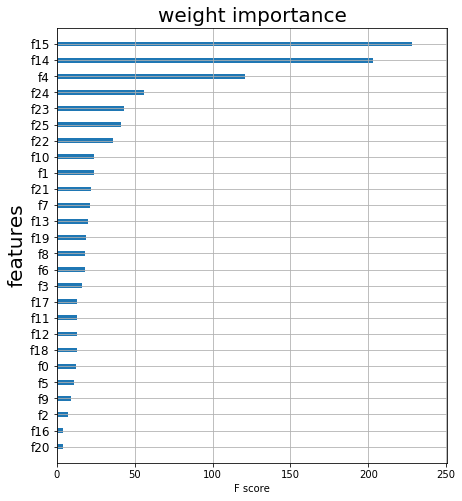

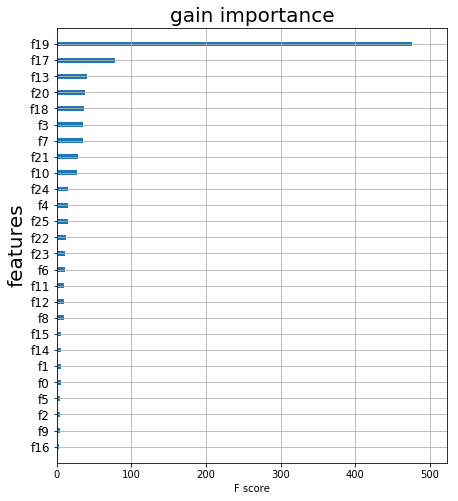

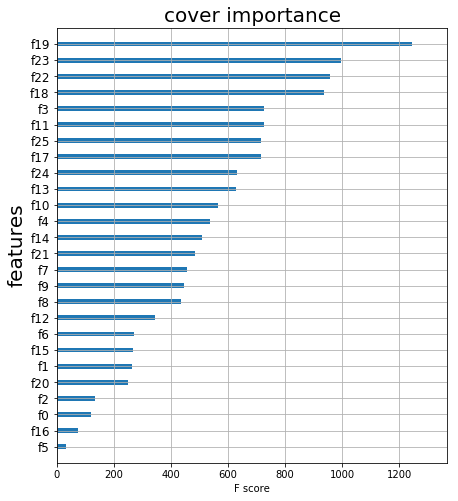

In [9]:
########## Feature importance 


### Feature Importance type = 'weight'
plt.figure(figsize = (7,8))
ax = plt.subplot()
xgb.plot_importance(classifier, importance_type='weight', ax=ax, height= 0.3, show_values=False), 
plt.title('weight importance', fontsize = 20)
plt.yticks(fontsize = 12)
plt.ylabel('features', fontsize = 20)

# This method give results that are closely related to what was observed in the previous part when we were having a look at several trees. 
# A big advantage is given to continuous features that are used a lot more to make a split in trees construction since they offer more split possibilities.  



### Feature Importance type = 'gain'
plt.figure(figsize = (7,8))
ax = plt.subplot()
xgb.plot_importance(classifier, importance_type='gain', ax=ax, height= 0.3, show_values=False), 
plt.title('gain importance', fontsize = 20)
plt.yticks(fontsize = 12)
plt.ylabel('features', fontsize = 20)

# Probably the best method. Most widely used. 
# Importance of Contract month to month is maybe a bit over-evaluated. The one of MonthlyCharges a bit under-evaluated. 



### Feature Importance type = 'cover'
plt.figure(figsize = (7,8))
ax = plt.subplot()
xgb.plot_importance(classifier, importance_type='cover', ax=ax, height= 0.3, show_values=False), 
plt.title('cover importance', fontsize = 20)
plt.yticks(fontsize = 12)
plt.ylabel('features', fontsize = 20)

# More balanced results - its use is not extremely spread.



In [15]:
### Permutation feature importance - (or Mean Decrease Accuracy)

# Import special library, designed for interpretation tasks
import eli5
from eli5.sklearn import PermutationImportance

#Fit and see permutation importance on our training data
perm_train = PermutationImportance(classifier)
perm_train.fit(X_train, y_train)
eli5.explain_weights_df(perm_train, feature_names=features)

# For this method, it is not clear on what set it should be applied. 
# In both cases, we can observe a table where features are ranked according to their importance. 
# The output takes the form of a weight (along with a standard deviation measure)

feature    weight       std
0                                    tenure  0.047474  0.003002
1     PaymentMethod_Credit card (automatic)  0.031496  0.001115
2   PaymentMethod_Bank transfer (automatic)  0.028306  0.002145
3                   Contract_Month-to-month  0.026879  0.001135
4                PaymentMethod_Mailed check  0.026372  0.001975
5                              TotalCharges  0.022117  0.001346
6                            MonthlyCharges  0.020643  0.001046
7                        InternetService_No  0.014092  0.001757
8               InternetService_Fiber optic  0.013609  0.000797
9            PaymentMethod_Electronic check  0.011506  0.001535
10                              TechSupport  0.008025  0.001274
11                              StreamingTV  0.006116  0.000993
12                         PaperlessBilling  0.006091  0.001138
13                           OnlineSecurity  0.005390  0.001120
14                        Contract_Two year  0.004327  0.001035
15                            MultipleLines  0.003650  0.001001
16                               Dependents  0.003626  0.001123
17                        Contract_One year  0.002562  0.000623
18                            SeniorCitizen  0.002562  0.000609
19                         DeviceProtection  0.001837  0.000515
20                             PhoneService  0.001837  0.000141
21                             OnlineBackup  0.001716  0.000428
22                                   gender  0.000725  0.000306
23                          StreamingMovies  0.000556  0.000665
24                                  Partner -0.000048  0.000394
25                      InternetService_DSL -0.000073  0.000059

In [16]:
# For feature importance, results vary according to the method used. Take into account the limitations / biases of each method 
# Combinining them allows to get a more objective view of the true feature importance, which is a great explanation factor. 
# Cross compare with deductions made during the data visualisation phase, where each feature's impact on churn was more or less assessed. 

In [3]:
# Feature interaction 
# Compute Friedman's H-statistics
# Import library 
from sklearn_gbmi import *

# Between any pairs of features
h_all_pairs(model2, X_train2.iloc[range(int(8274))])

{('Contract_Month-to-month', 'Contract_One year'): 0.06398625830579517,
 ('Contract_Month-to-month', 'Contract_Two year'): 0.09908809594947678,
 ('Contract_Month-to-month',
  'PaymentMethod_Bank transfer (automatic)'): 0.03244117678100048,
 ('Contract_Month-to-month',
  'PaymentMethod_Credit card (automatic)'): 0.022206372670315676,
 ('Contract_Month-to-month',
  'PaymentMethod_Electronic check'): 0.03853269695219445,
 ('Contract_Month-to-month',
  'PaymentMethod_Mailed check'): 0.005398396423834397,
 ('Contract_One year', 'Contract_Two year'): 0.19097419891231243,
 ('Contract_One year',
  'PaymentMethod_Bank transfer (automatic)'): 7.139786747981741e-16,
 ('Contract_One year',
  'PaymentMethod_Credit card (automatic)'): 0.0020003851709962848,
 ('Contract_One year',
  'PaymentMethod_Electronic check'): 2.3129445991150862e-15,
 ('Contract_One year', 'PaymentMethod_Mailed check'): 4.5583640941167e-16,
 ('Contract_Two year',
  'PaymentMethod_Bank transfer (automatic)'): 0.0162386990904779

In [24]:

########## Global Surrogate Model (Decision Tree)


# Import libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score


# We approximate the predictions of our XGBClassifier by a CART Decision Tree. 
# We train it on the training dataset (X_train, y_pred) where y_pred are the predictions of our true XGBClassifier model. 

# As a result, we have 3863 predicted non churners and 4411 churners since we use predictions of the black box. 
# Note that using true value, we would have 4137 of each class. 
y_pred2[y_pred2==0].shape # non churners
y_pred2[y_pred2==1].shape # churners

# Fit the Decision Tree, which was tuned using GridSearchCV
classifier2 = DecisionTreeClassifier(criterion = 'entropy', max_depth = 7, max_features = None, min_samples_leaf = 0.0005, min_samples_split = 0.008)  #min_impurity_decrease = 
classifier2.fit(X_train, y_pred2)

#Predict the training results and extend to test set. Compare. 
DT_y_pred2 = classifier2.predict(X_train)
DT_y_pred = classifier2.predict(X_test)

# Evaluate performance using R^2. Confusion matrix. 
tree_performance = r2_score(DT_y_pred2 , y_pred2)
tree_performance2 = roc_auc_score(DT_y_pred2, y_pred2)
tree_perf = r2_score(DT_y_pred , y_pred)
tree_perf2 = roc_auc_score(DT_y_pred , y_pred)  
tree_p = accuracy_score(DT_y_pred2 , y_pred2) 
tree_p2 = accuracy_score(DT_y_pred , y_pred)           
print('Training r2: '+ str(tree_performance), 'Test r2 : ' + str (tree_perf))
print('Training AUC: '+  str(tree_performance2) ,'Test AUC: ' + str(tree_perf2))
print('Training accuracy: ' + str(tree_p), 'Test accuracy : ' + str (tree_p2))
# This (global) surrogate model is a good approximation of the black box. 
# The R^2 equals approximately 0.72 and the AUC is excellent (around 0.9) for the training set. For the test set, we obtain respectively 0.63 and 0.89. 
# If R^2 was moderatly higher, then we could have used a Decision Tree instead of XGBoost. If it was lower, global surrogate model would not have been great. 
# R^2 is the most important measure, even for classification tasks, to see if the surrogate model is a good approximation. 

# Training set confusion matrix 
cm = confusion_matrix(DT_y_pred2, y_pred2)
print(cm)
# Test set confusion matrix 
cm2 = confusion_matrix(DT_y_pred, y_pred)
print(cm2)
# Excellent results. Good surrogate model. 
# Notice class unbalance for test set and SMOTE's effect on training set. 

('Training r2: 0.7061538402739783', 'Test r2 : 0.6326180498310336')
('Training AUC: 0.9270591811637258', 'Test AUC: 0.8983871594239177')
('Training accuracy: 0.9270002417210539', 'Test accuracy : 0.914001421464108')
[[3534  275]
 [ 329 4136]]
[[846  35]
 [ 86 440]]


In [25]:
# Plot Decision Tree
from sklearn.tree import export_graphviz
import graphviz
dot_data = export_graphviz(classifier2, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("DecisionTree") 
# We could not make it much smaller without sacrificing quite a lot of performance. We already limited its size! 
# This means that it would not have been such a good global surrogate model. 
# If we decrease max_depth to 6, we lose 0.1 point of R^2 in both the training and test set. 


# We could use some interpretable methods on this decision tree. 
# Since this approach is not really rigorous, I will not use it too much to get additional information about the original's model functioning, but note that this could be done. 
# I just have a quick look at feature importance

'DecisionTree.pdf'

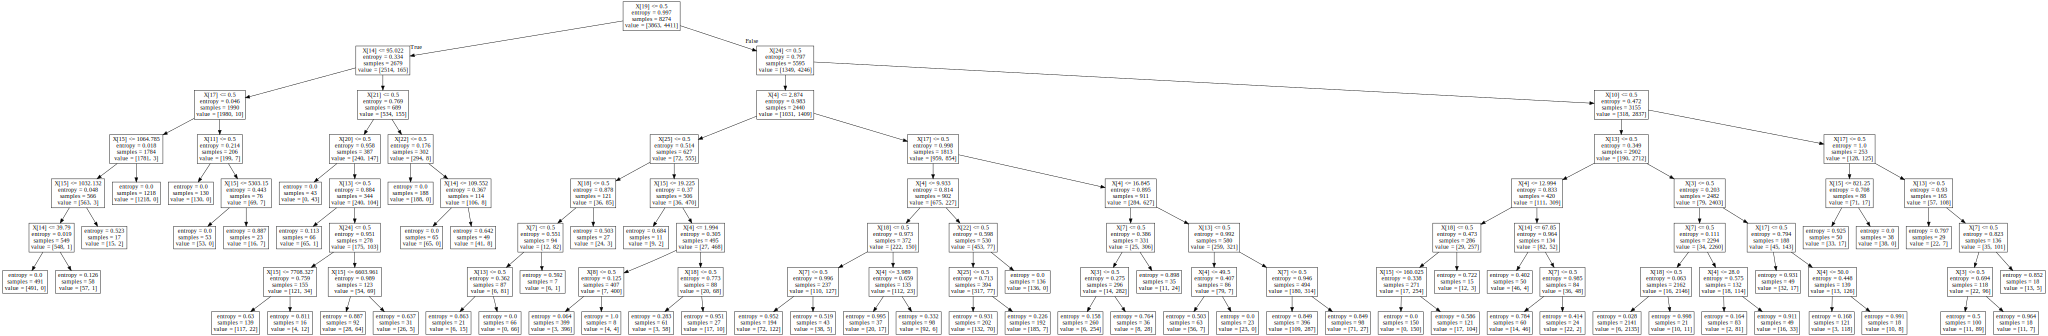

In [26]:
graph

[('Contract_Month-to-month', 0.46),
 ('tenure', 0.1),
 ('PaymentMethod_Electronic check', 0.1),
 ('InternetService_Fiber optic', 0.06),
 ('PaperlessBilling', 0.05),
 ('MonthlyCharges', 0.05),
 ('TechSupport', 0.04),
 ('OnlineSecurity', 0.03),
 ('InternetService_No', 0.03),
 ('Dependents', 0.02),
 ('TotalCharges', 0.02),
 ('Contract_Two year', 0.02),
 ('Contract_One year', 0.01),
 ('PaymentMethod_Bank transfer (automatic)', 0.01),
 ('PaymentMethod_Mailed check', 0.01),
 ('gender', 0.0),
 ('SeniorCitizen', 0.0),
 ('Partner', 0.0),
 ('PhoneService', 0.0),
 ('MultipleLines', 0.0),
 ('OnlineBackup', 0.0),
 ('DeviceProtection', 0.0),
 ('StreamingTV', 0.0),
 ('StreamingMovies', 0.0),
 ('InternetService_DSL', 0.0),
 ('PaymentMethod_Credit card (automatic)', 0.0)]

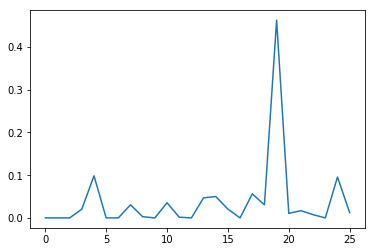

In [28]:
# Feature importance 
DT_feat_imp = classifier2.feature_importances_
# Graph of feature importance 
k = list(range(0,26))
plt.plot(k, DT_feat_imp)   
# Get numerical feature importances. 
DT_importances = list(classifier2.feature_importances_)
DT_feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features, DT_importances)]
DT_feature_importances = sorted(DT_feature_importances, key = lambda x: x[1], reverse = True)
# print('Variable: {:20} Importance: {}'.format(*pair)) for pair in DT_feature_importances ONLY PYTHON3
# You can compare these results with XGBoost's individual trees and XGBoost's feature importance output. 
DT_feature_importances


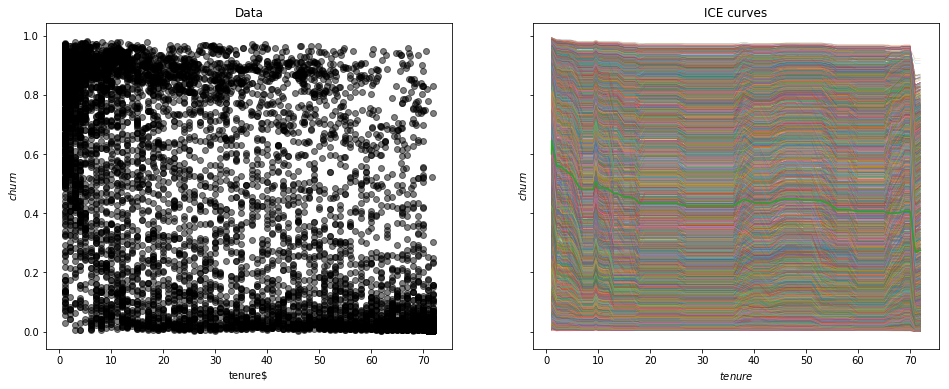

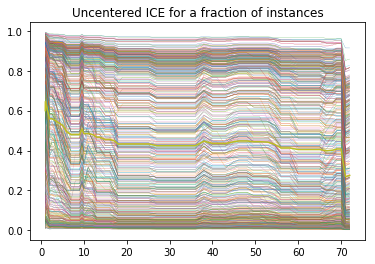

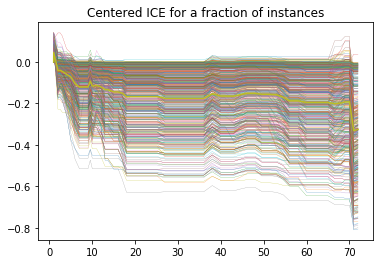

Text(0.5,1,'PDP plot of tenure')

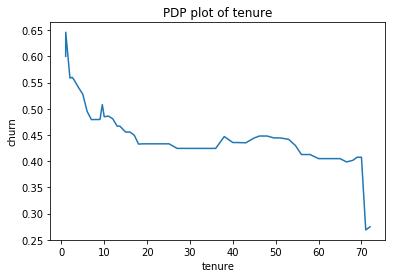

In [32]:
############### Individual Conditional Expectations (ICE) & Partial Dependence Plots (PDP)



# Import libraries 
from pycebox.ice import ice, pdp, ice_plot


# Define two important concepts in order to center ICEs and plot only a fraction of them. 
def _get_quantiles(x):
    return np.greater.outer(x, x).sum(axis=1) / x.size

def ICE_plot(ice_data, frac_to_plot=1.,
             plot_points=False, point_kwargs=None,
             x_quantile=False, plot_pdp=False,
             centered=False, centered_quantile=0.,
             color_by=None, cmap=None,
             ax=None, pdp_kwargs=None, **kwargs):
    """
    Plot the ICE curves
    :param ice_data: the ICE data generated by :func:`pycebox.ice.ice`
    :type ice_data: ``pandas`` ``DataFrame``
    :param frac_to_plot: the fraction of ICE curves to plot.  If less than one,
        randomly samples columns of ``ice_data`` to plot.
    :type frac_to_plot: ``float``
    :param plot_points: whether or not to plot the original data points on the
        ICE curves.  In this case, ``point_kwargs`` is passed as keyword
        arguments to plot.
    :type plot_points: ``bool``
    :param x_quantile: if ``True``, the plotted x-coordinates are the quantiles of
        ``ice_data.index``
    :type x_quantile: ``bool``
    :param plot_pdp: if ``True``, plot the partial depdendence plot.  In this
        case, ``pdp_kwargs`` is passed as keyword arguments to ``plot``.
    :param centered: if ``True``, each ICE curve is centered to zero at the
        percentile closest to ``centered_quantile``.
    :type centered: ``bool``
    :param color_by:  If a string, color the ICE curve by that level of the
        column index.
        If callable, color the ICE curve by its return value when applied to a
        ``DataFrame`` of the column index of ``ice_data``
    :type color_by: ``None``, ``str``, or callable
    :param cmap:
    :type cmap: ``matplotlib`` ``Colormap``
    :param ax: the ``Axes`` on which to plot the ICE curves
    :type ax: ``None`` or ``matplotlib`` ``Axes``
    Other keyword arguments are passed to ``plot``
    """
    if not ice_data.index.is_monotonic_increasing:
        ice_data = ice_data.sort_index()

    if centered:
        quantiles = _get_quantiles(ice_data.index)
        centered_quantile_iloc = np.abs(quantiles - centered_quantile).argmin()
        ice_data = ice_data - ice_data.iloc[centered_quantile_iloc]

    if frac_to_plot < 1.:
        n_cols = ice_data.shape[1]
        icols = np.random.choice(n_cols, size= int(frac_to_plot * n_cols), replace=False)
        plot_ice_data = ice_data.iloc[:, icols]
    else:
        plot_ice_data = ice_data


    if x_quantile:
        x = _get_quantiles(ice_data.index)
    else:
        x = ice_data.index

    if plot_points:
        point_x_ilocs = _get_point_x_ilocs(plot_ice_data.index, plot_ice_data.columns)
        point_x = x[point_x_ilocs]
        point_y = plot_ice_data.values[point_x_ilocs, np.arange(point_x_ilocs.size)]

    if ax is None:
        _, ax = plt.subplots()

    if color_by is not None:
        if isinstance(color_by, six.string_types):
            colors_raw = plot_ice_data.columns.get_level_values(color_by).values
        elif hasattr(color_by, '__call__'):
            col_df = pd.DataFrame(list(plot_ice_data.columns.values), columns=plot_ice_data.columns.names)
            colors_raw = color_by(col_df)
        else:
            raise ValueError('color_by must be a string or function')

        norm = colors.Normalize(colors_raw.min(), colors_raw.max())
        m = cm.ScalarMappable(norm=norm, cmap=cmap)

        for color_raw, (_, ice_curve) in zip(colors_raw, plot_ice_data.iteritems()):
            c = m.to_rgba(color_raw)
            ax.plot(x, ice_curve, c=c, zorder=0, **kwargs)
    else:
        ax.plot(x, plot_ice_data, zorder=0, **kwargs)

    if plot_points:
        ax.scatter(point_x, point_y, zorder=10, **(point_kwargs or {}))

    if plot_pdp:
        pdp_kwargs = pdp_kwargs or {}
        pdp_data = pdp(ice_data)
        ax.plot(x, pdp_data, **pdp_kwargs)

    return ax



# For the variable TENURE, create its ICE function
# As mentionned earlier, we are using the predicted probability that a customer will churn as target variable. 
ice_tenure = ice(X_train2, 'tenure', regressor.predict, num_grid_points=72) # Here 72 grid points because tenure can take 72 values. The more grid points, the more accurate it would be.  
ice_tenure.head() # Each column corresponds to a datapoint

# Data points plots and ICE plots. Run 2 parts together to obtain both plots. 
fig, (data_ax, ice_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(16, 6))
data_ax.scatter(X_train2.tenure, y2_pred2, c='k', alpha=0.5);
data_ax.set_xlabel('tenure$');
data_ax.set_ylabel('$churn$');
data_ax.set_title('Data');
# This is a first version of ICE. It is too crowded and uncentered, which we will try to modify. 
ice_plot(ice_tenure, ax=ice_ax, plot_points=False, linewidth=0.2, plot_pdp = True); # frac_to_plot = 0.1  ;  the fraction of ICE curves to plot.
ice_ax.set_xlabel('$tenure$');
ice_ax.set_ylabel('$churn$');
ice_ax.set_title('ICE curves');

# Play with the following parameters of ice and ice_plot: num_grid_points, frac_to_plot, centered and plot_points. 

# New centered-ICE plots, still for tenure and with only a fraction of the total number of instances being considered. 
ICE_plot(ice_tenure, plot_points=False, linewidth=0.2, plot_pdp = True, frac_to_plot = 0.08)
plt.title('Uncentered ICE for a fraction of instances')
ICE_plot(ice_tenure, plot_points=False, linewidth=0.2, plot_pdp = True, frac_to_plot = 0.08, centered=True)
plt.title('Centered ICE for a fraction of instances')
plt.show()

# PDP for 'tenure': created manually from definition of 'pycebox.ice.pdp'
plt.plot(ice_tenure.index, ice_tenure.mean(axis=1))
plt.xlabel('tenure')
plt.ylabel('churn')
plt.title('PDP plot of tenure')

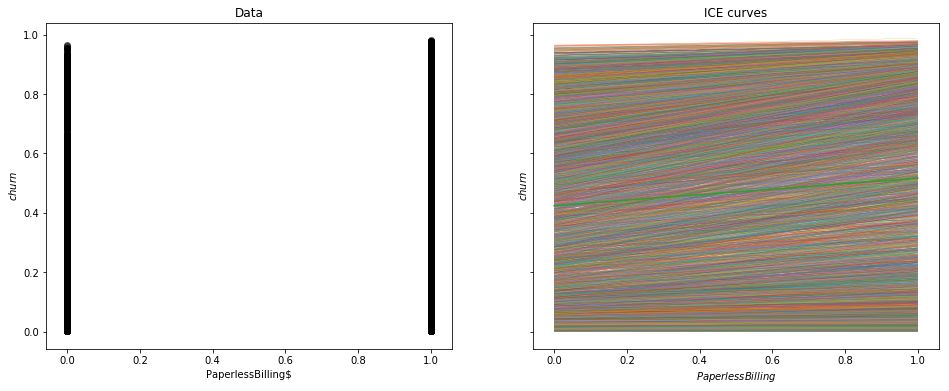

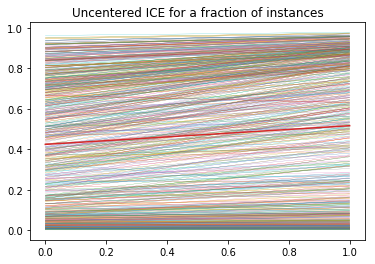

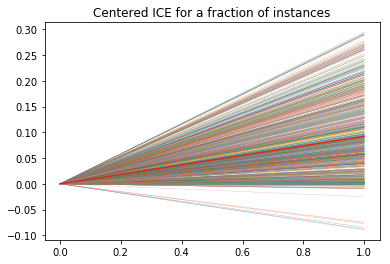

Text(0.5,1,'PDP for PaperlessBilling')

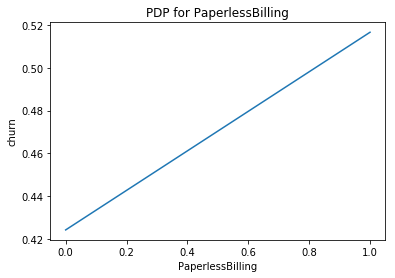

In [34]:
# PAPERLESS BILLING
ice_PB = ice(X_train2, 'PaperlessBilling', regressor.predict, num_grid_points=2)
# Data points plots and ICE plots. Plot together
fig, (data_ax, ice_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(16, 6))
data_ax.scatter(X_train2.PaperlessBilling, y2_pred2, c='k', alpha=0.5);
data_ax.set_xlabel('PaperlessBilling$');
data_ax.set_ylabel('$churn$');
data_ax.set_title('Data');
# This is a first version of ICE. It is too crowded and uncentered, which we will try to modify. 
ice_plot(ice_PB, ax=ice_ax, plot_points=False, linewidth=0.2, plot_pdp = True); # frac_to_plot = 0.1  ;  the fraction of ICE curves to plot.
ice_ax.set_xlabel('$PaperlessBilling$');
ice_ax.set_ylabel('$churn$');
ice_ax.set_title('ICE curves');
ICE_plot(ice_PB, plot_points=False, linewidth=0.2, plot_pdp = True, frac_to_plot = 0.1)
plt.title('Uncentered ICE for a fraction of instances')
ICE_plot(ice_PB, plot_points=False, linewidth=0.2, plot_pdp = True, frac_to_plot = 0.1, centered=True)
plt.title('Centered ICE for a fraction of instances')
plt.show()
# PDP for 'tenure': created manually from definition of 'pycebox.ice.pdp'
plt.plot(ice_PB.index, ice_PB.mean(axis=1))
plt.xlabel('PaperlessBilling')
plt.ylabel('churn')
plt.title('PDP for PaperlessBilling')

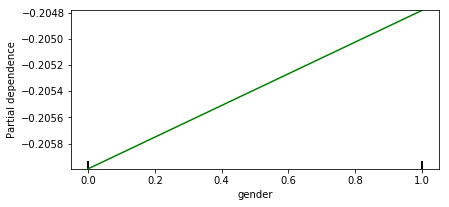

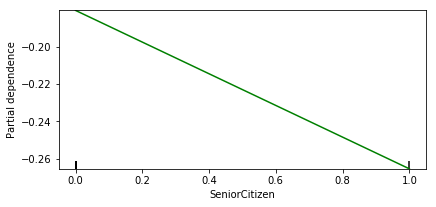

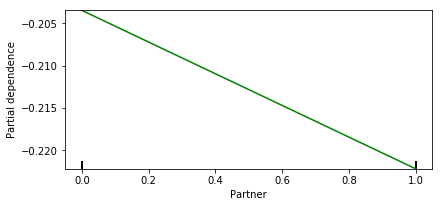

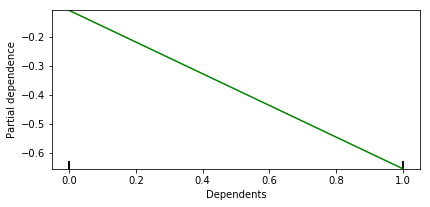

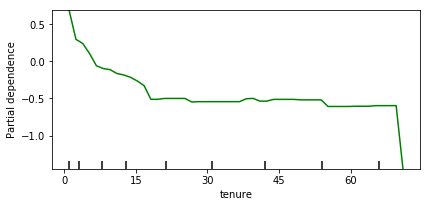

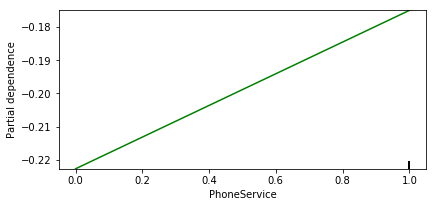

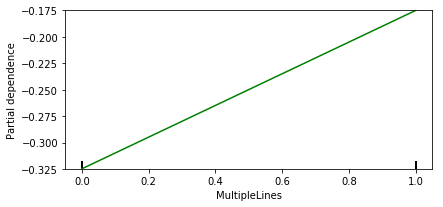

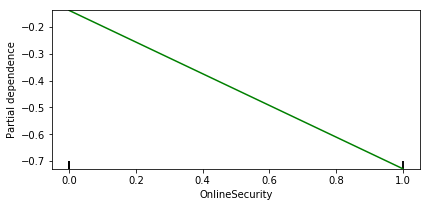

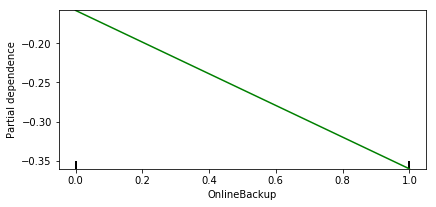

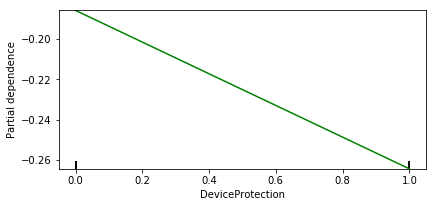

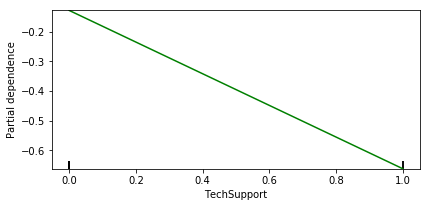

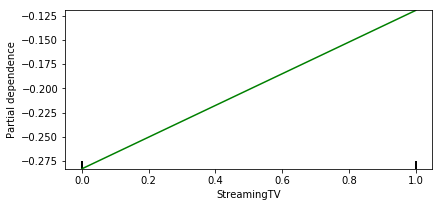

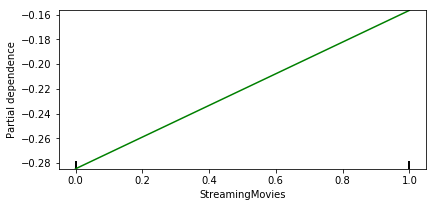

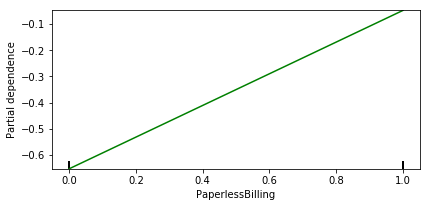

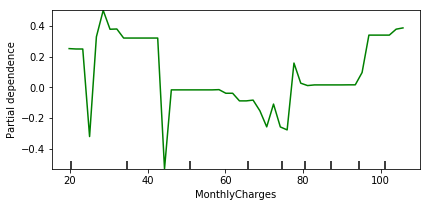

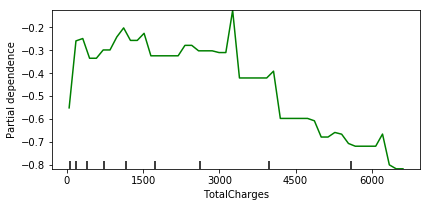

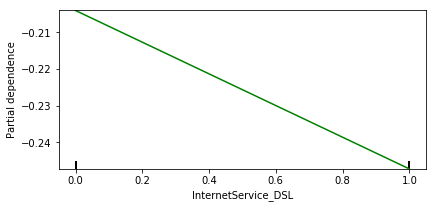

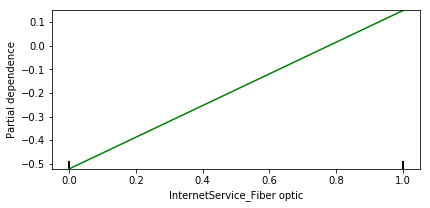

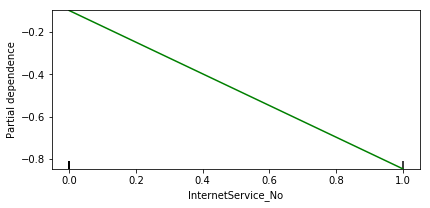

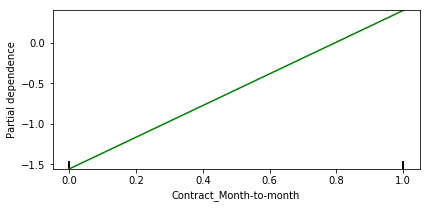

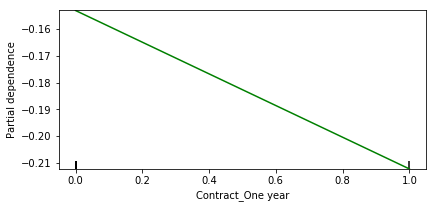

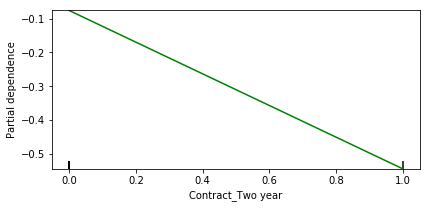

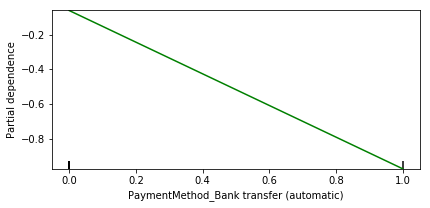

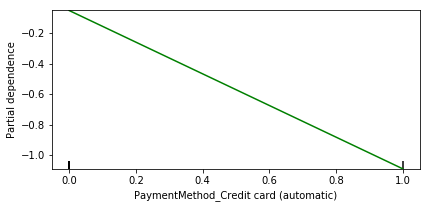

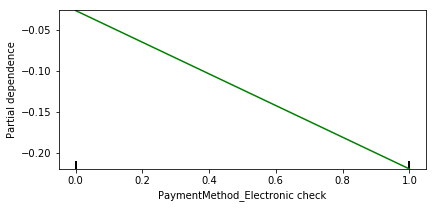

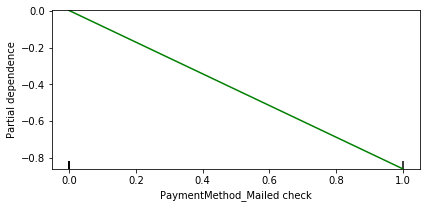

In [35]:
######  Further analysis on PDP ; other way to proceed 


# Import libraries
from pdpbox import pdp, get_dataset, info_plots
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence


# New options: PDP of multiple categorical features and 2 dimensional PDPs (at the end)
# Limit: use a GBM model because not available for classifier version of XGBoost. 



### Redo PDP of all covariates using another method. 

# Plot PDP using a GBM model, giving similar performances to the XGBoost model. 
for i in range(0, len(telcom.columns)-2): # CustomerID and Churn are not included in X_train
    feat = [i]
    fig, axs = plot_partial_dependence(model2, X_train, feat ,feature_names= features,n_jobs=3, grid_resolution=50)

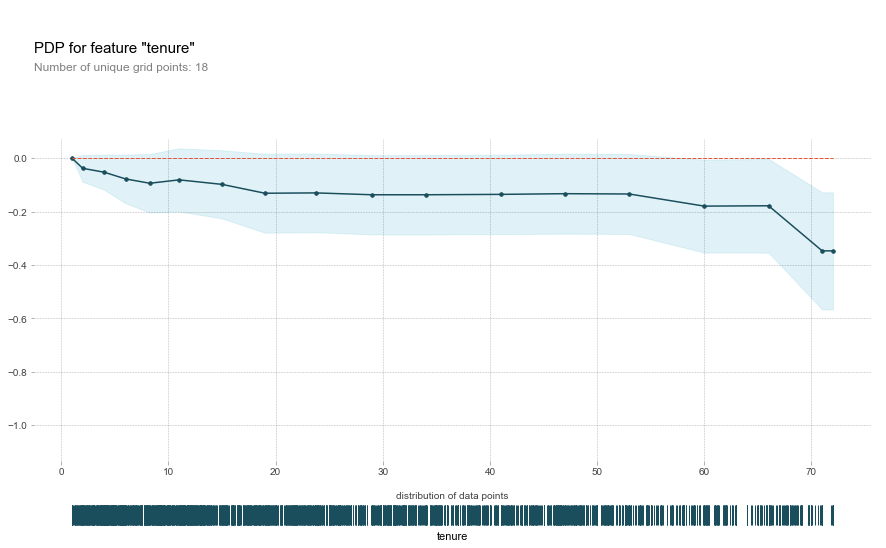

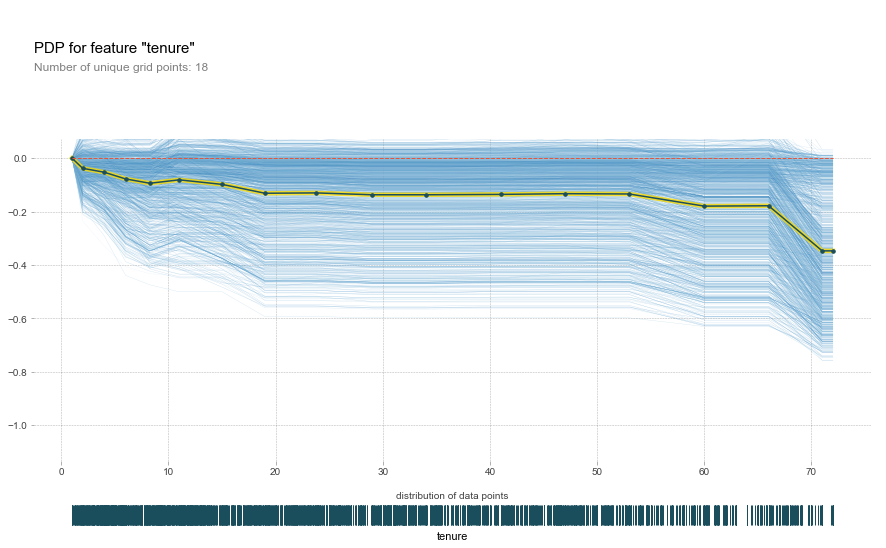

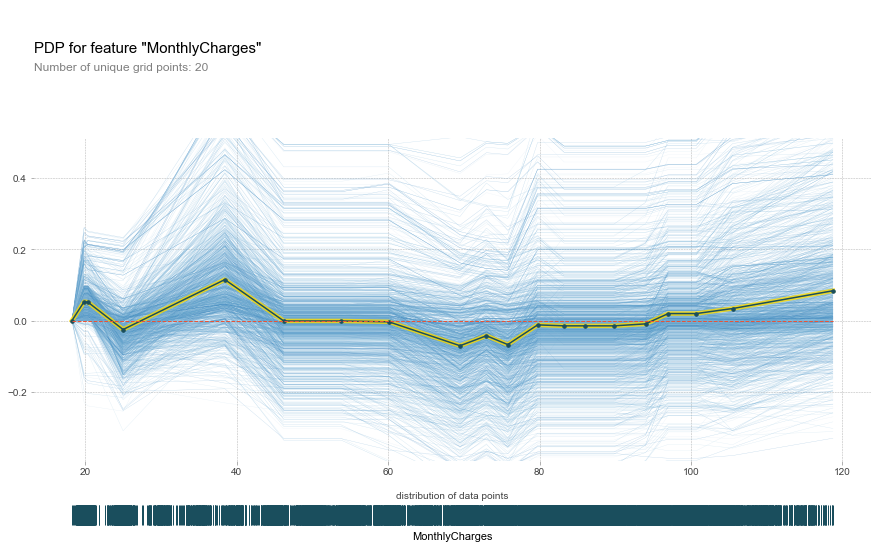

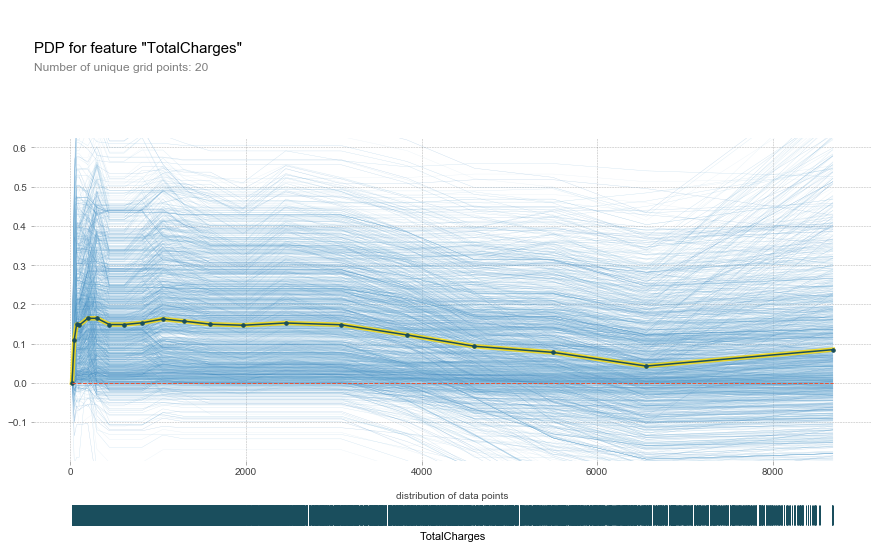

In [36]:
### Continuous variables 

# For the variable tenure (cts)  
pdp_tenure = pdp.pdp_isolate(model= model2, dataset=X_train2, model_features=features, feature='tenure', num_grid_points=20)
fig, axes = pdp.pdp_plot(pdp_tenure, 'tenure', plot_pts_dist=True) # plot
# Same graph -  Modified parameters _ with some ICE
fig, axes = pdp.pdp_plot(pdp_tenure, 'tenure',  center=True, plot_pts_dist= True, plot_lines= True, frac_to_plot=0.2) # plot

# MonthlyCharges
pdp_MC = pdp.pdp_isolate(model= model2, dataset=X_train2, model_features=features, feature='MonthlyCharges', num_grid_points=20)
fig, axes = pdp.pdp_plot(pdp_MC, 'MonthlyCharges',  center=True, plot_pts_dist= True, plot_lines= True, frac_to_plot=0.2) # plot

# TotalCharges
pdp_TC = pdp.pdp_isolate(model= model2, dataset=X_train2, model_features=features, feature='TotalCharges', num_grid_points=20)
fig, axes = pdp.pdp_plot(pdp_TC, 'TotalCharges',  center=True, plot_pts_dist= True, plot_lines= True, frac_to_plot=0.2) # plot

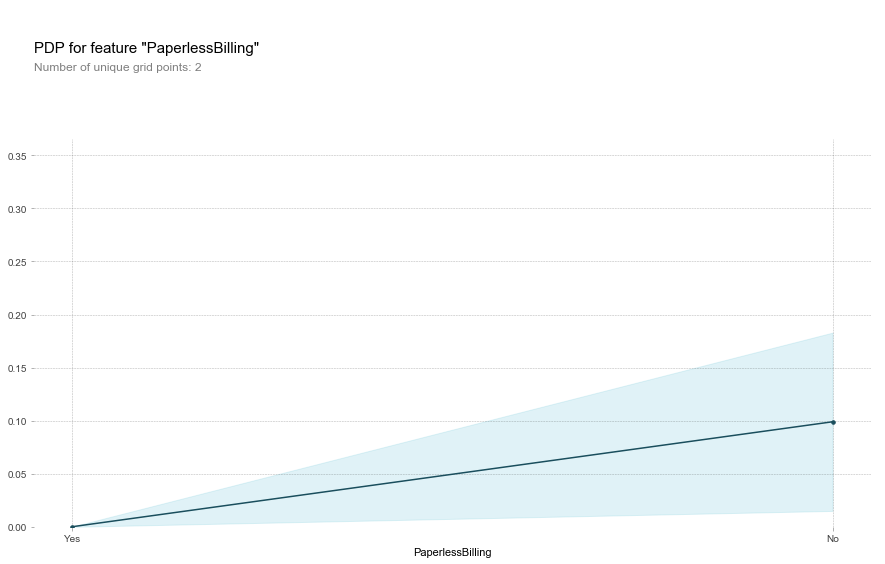

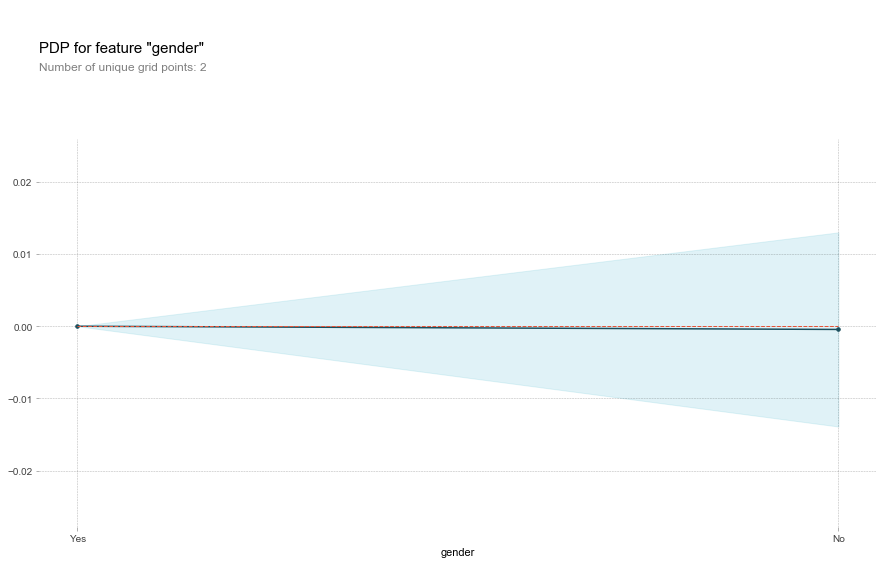

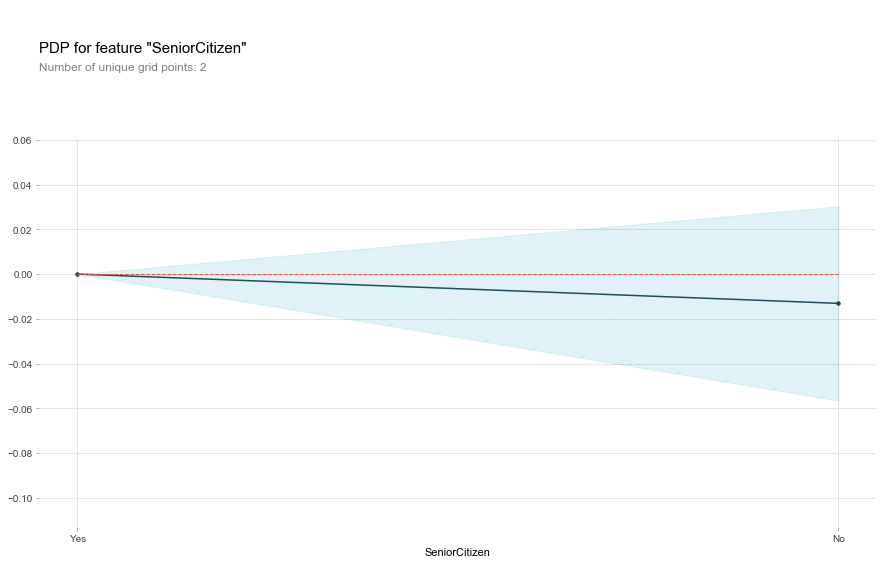

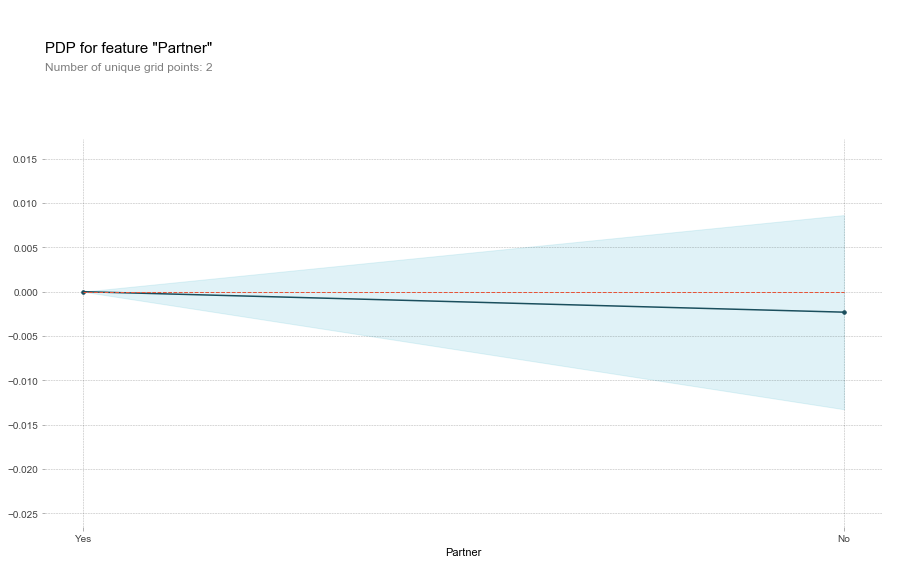

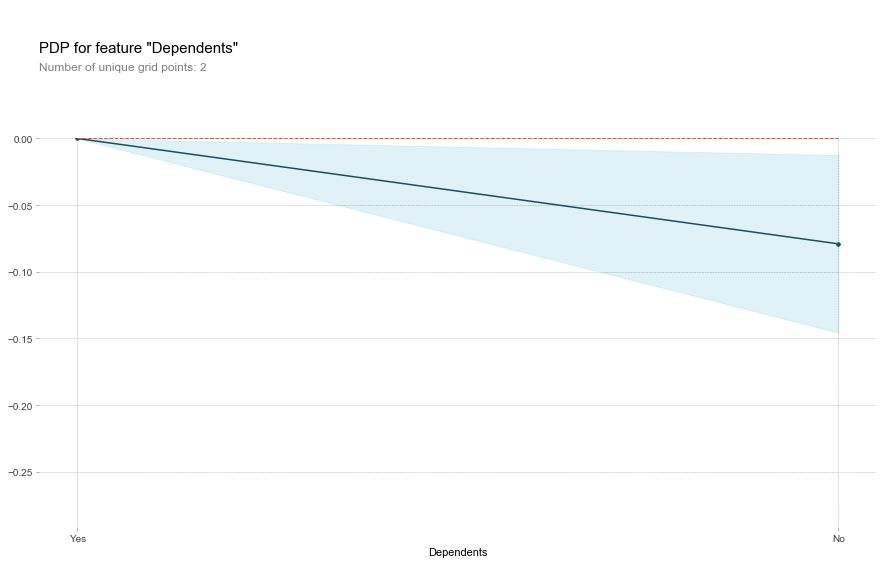

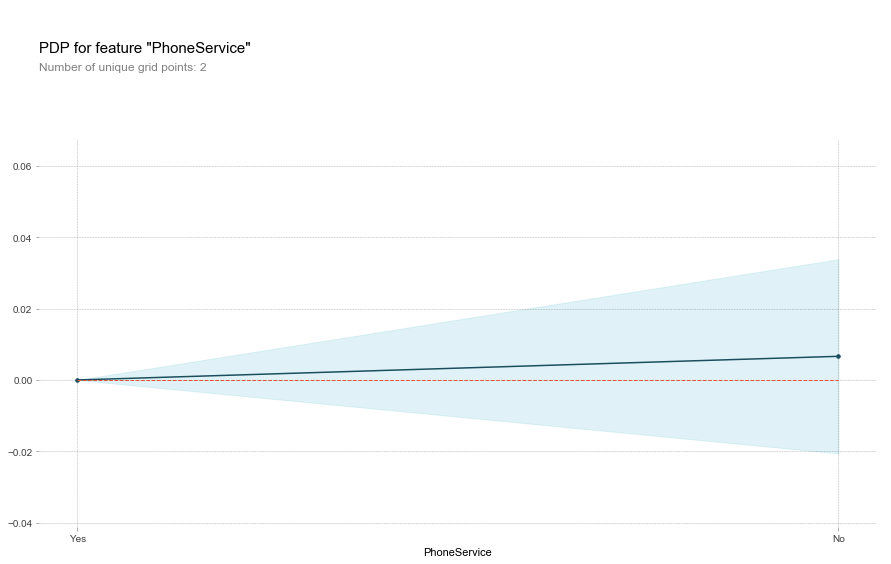

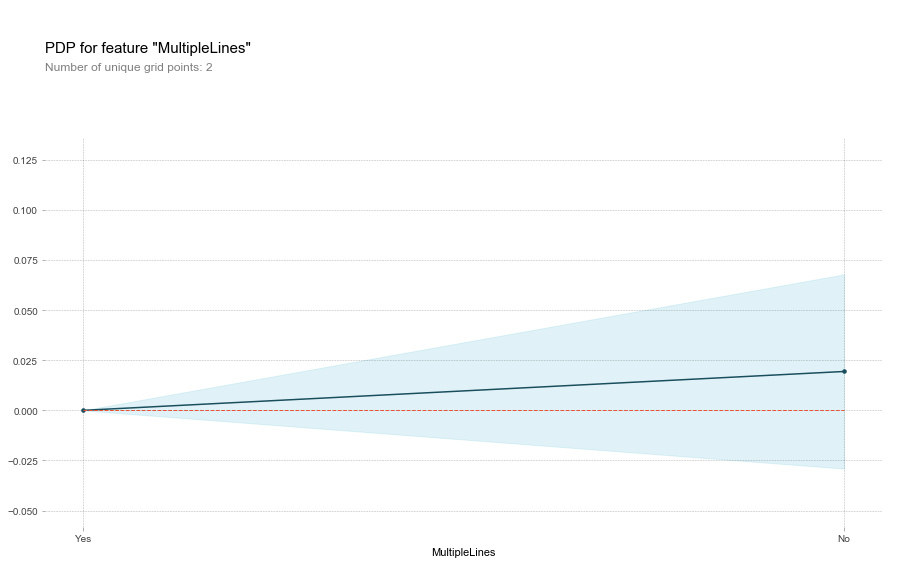

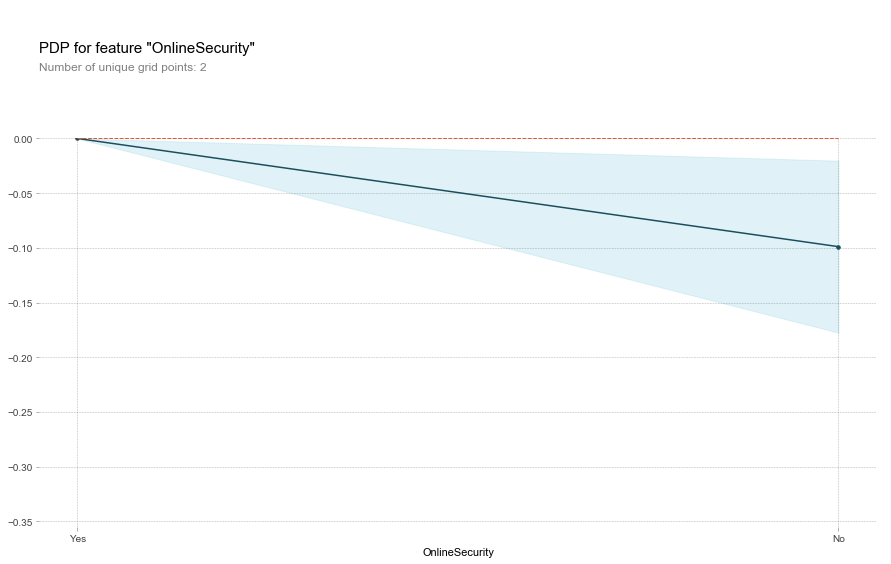

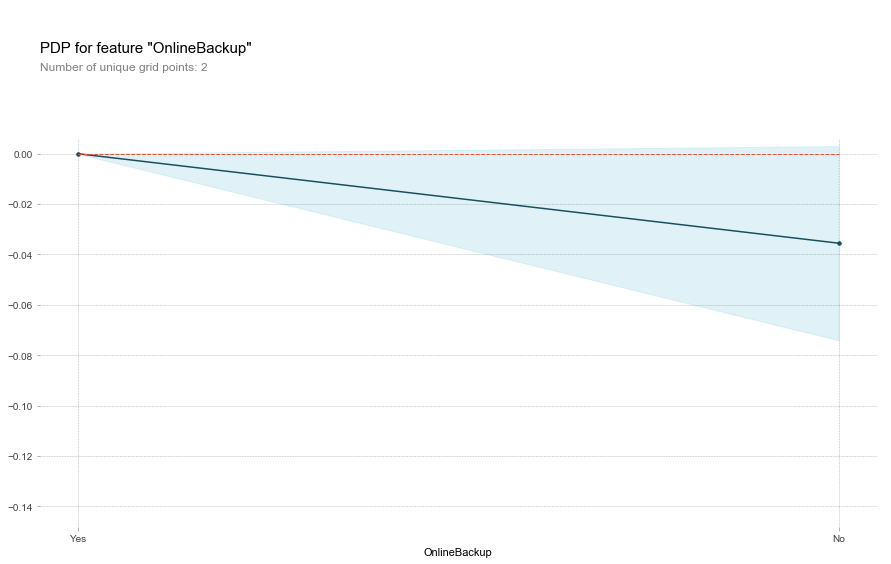

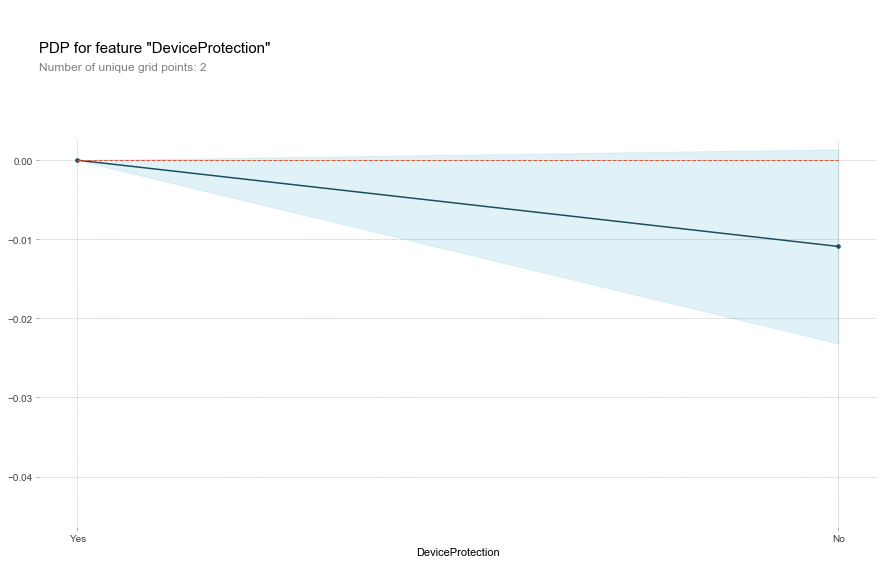

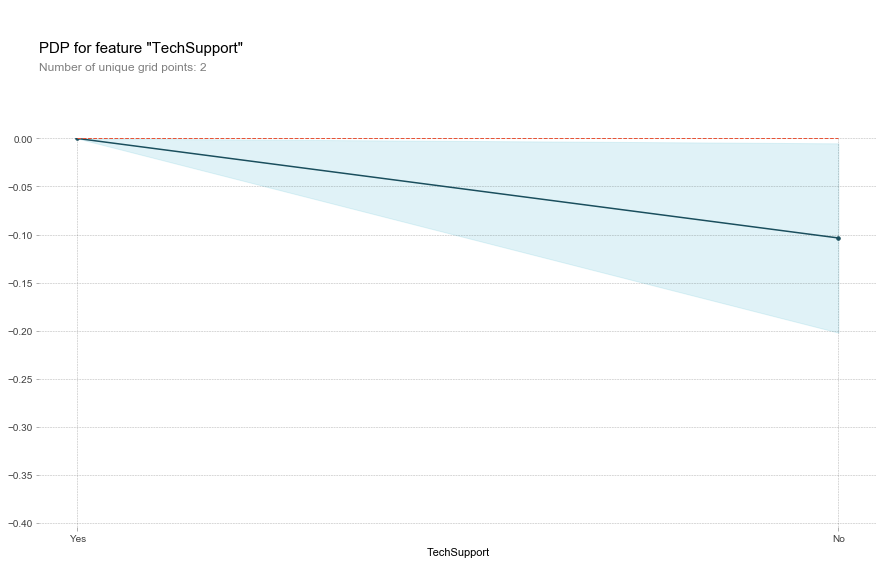

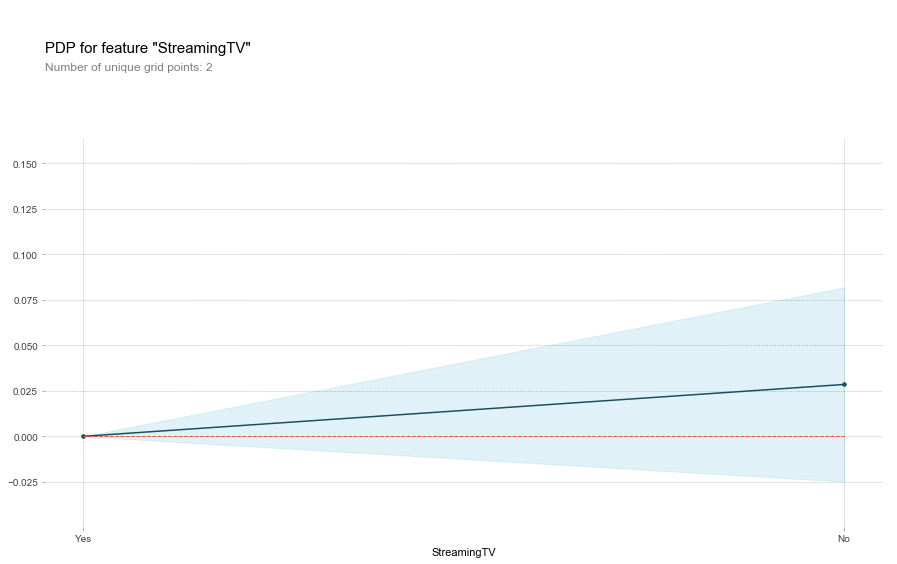

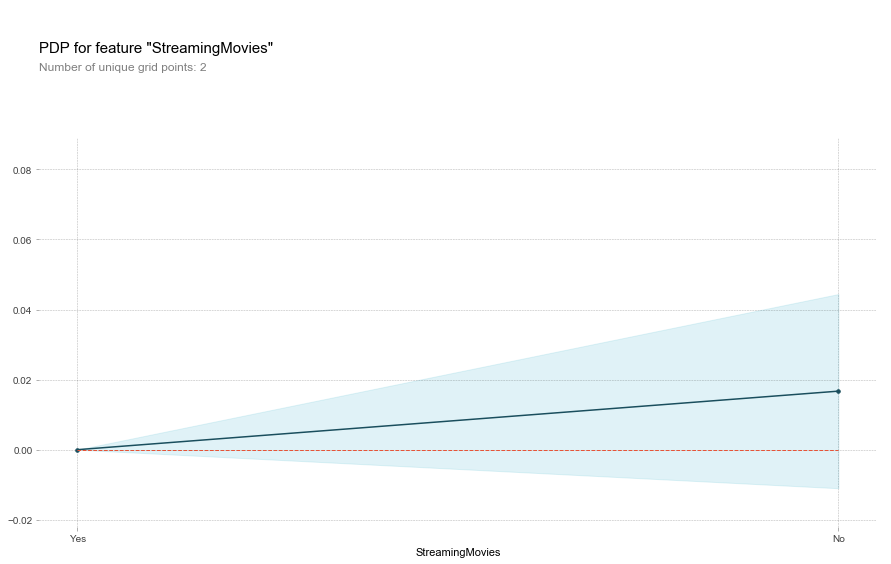

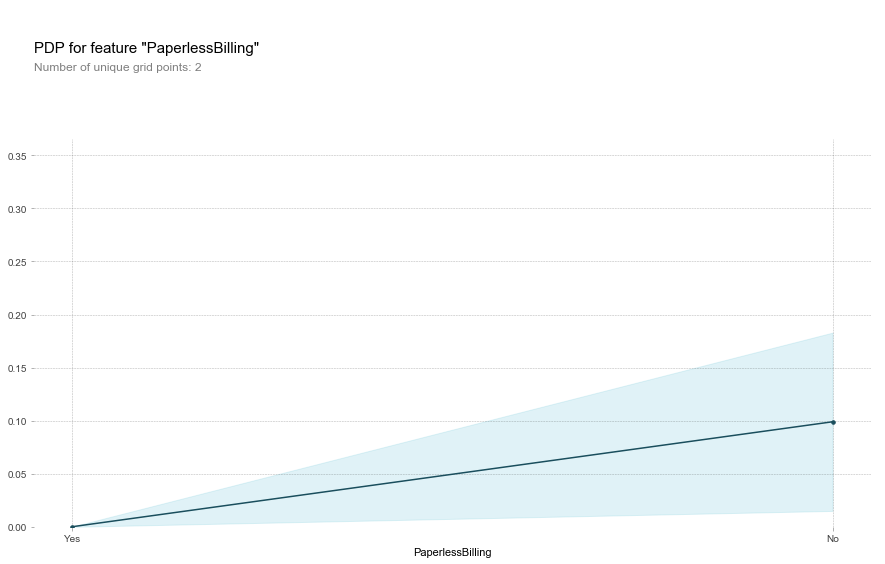

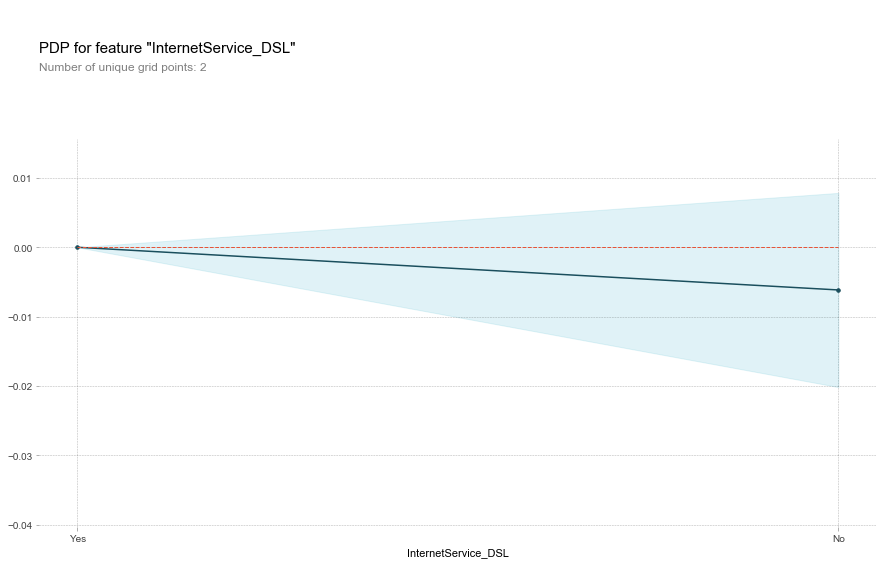

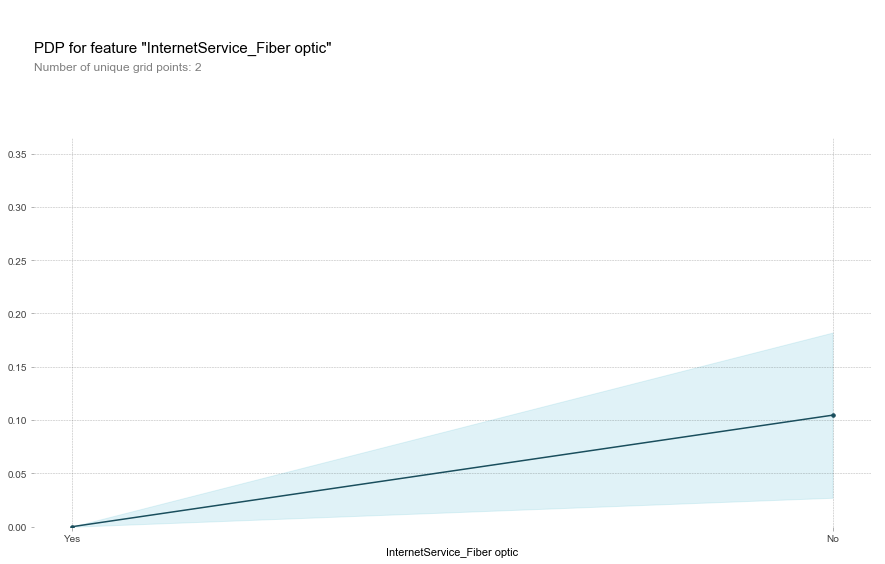

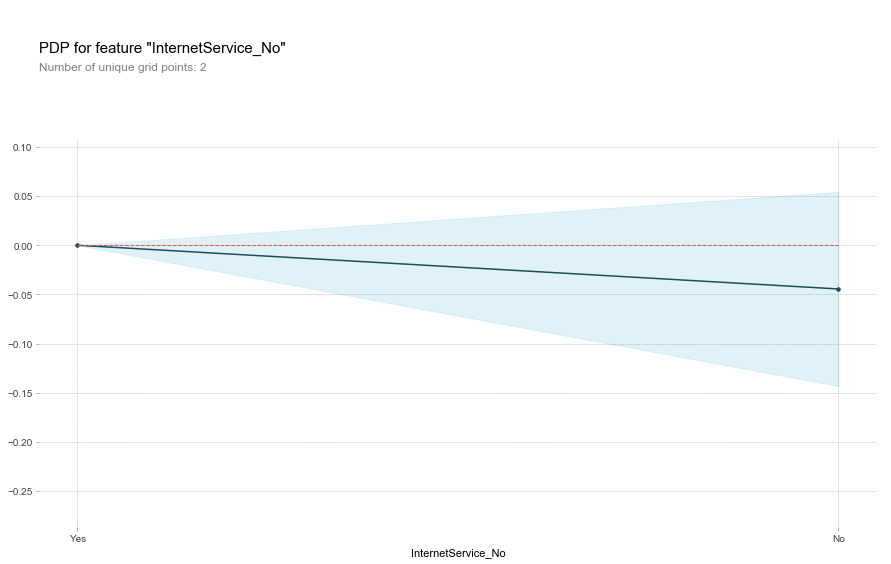

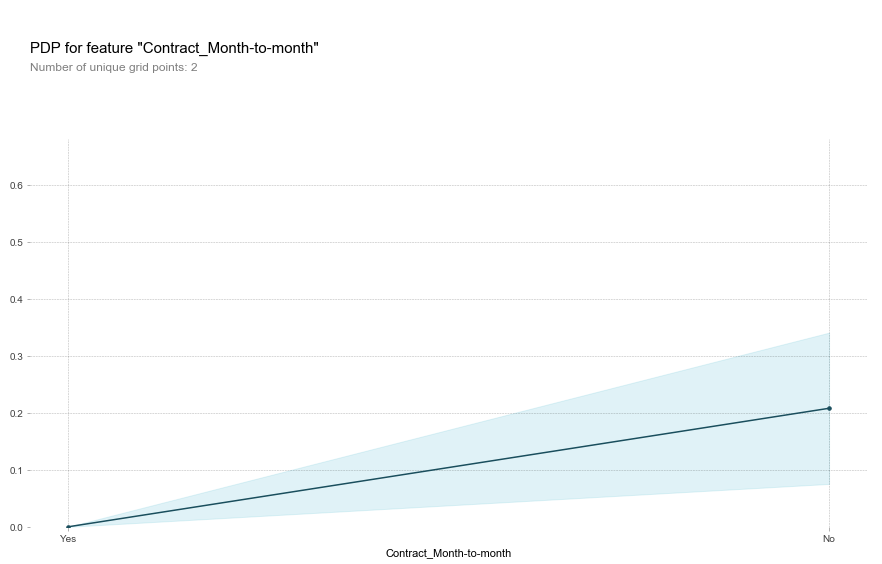

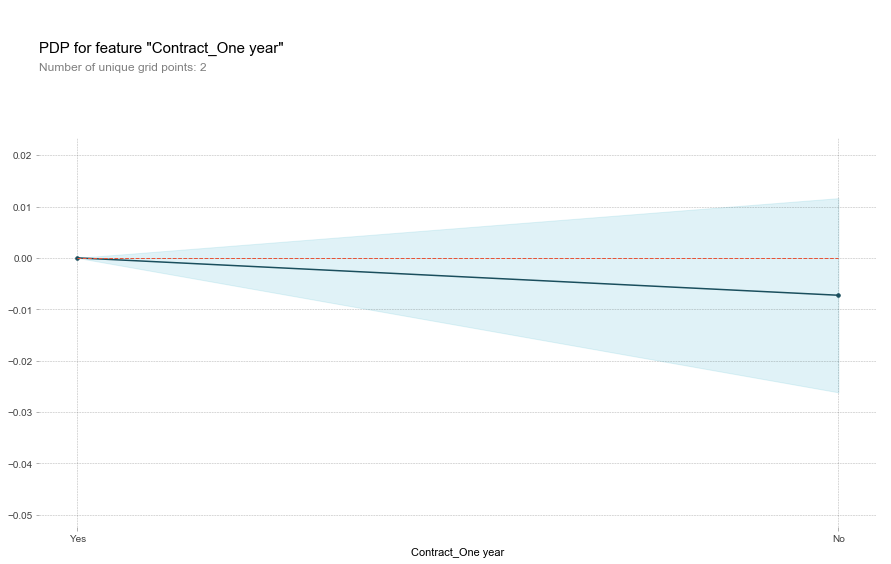

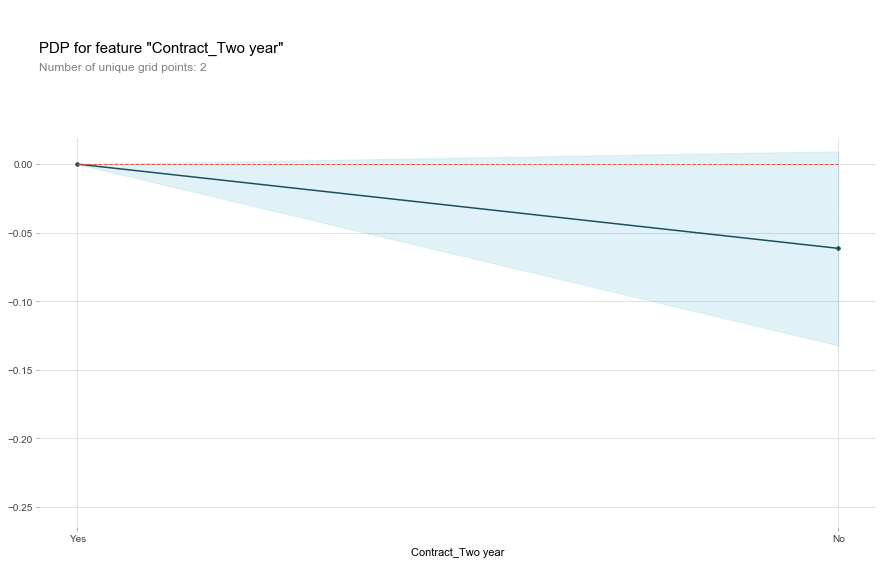

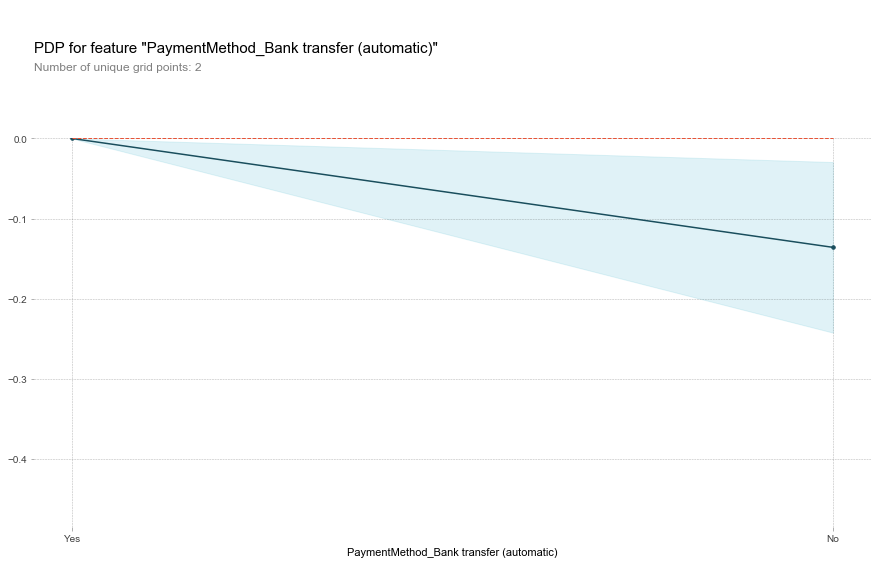

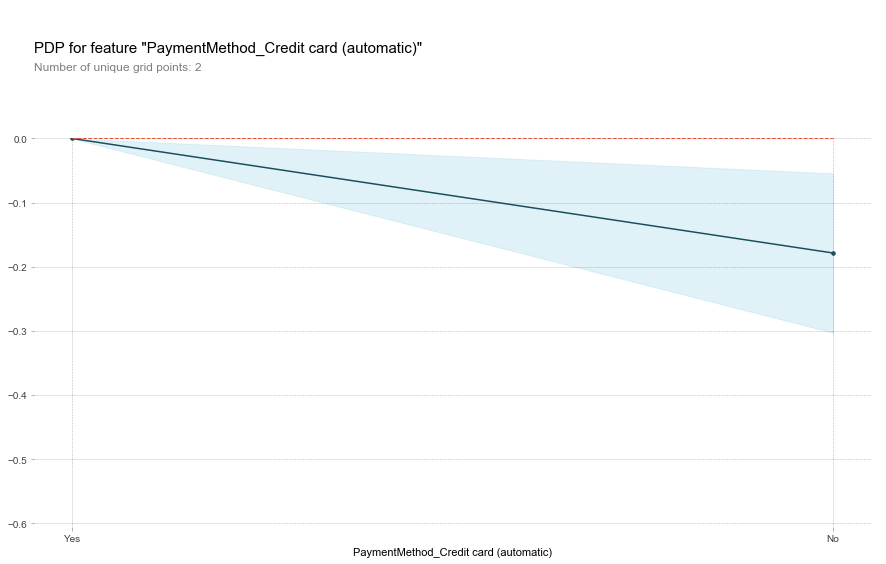

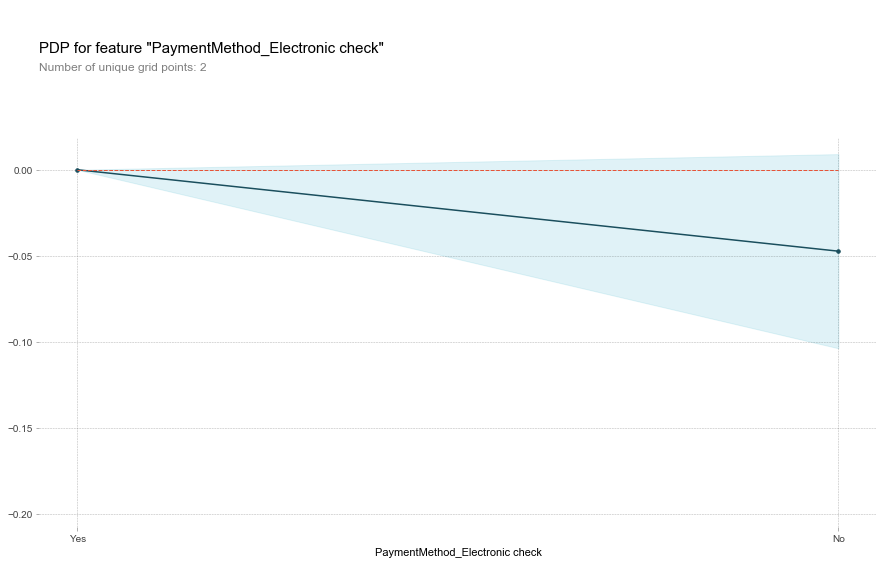

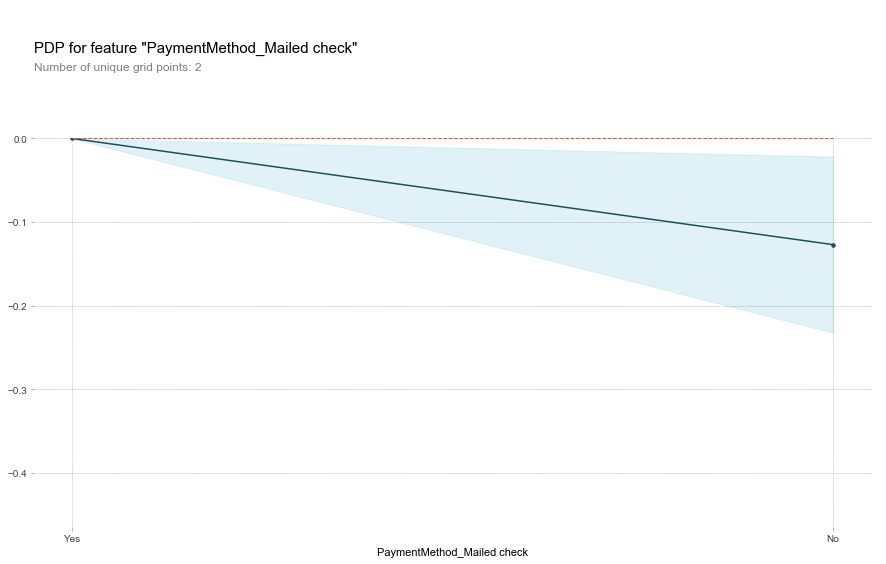

In [37]:

### Dummy variables 

# For PaperlessBilling (dummy variable)
pdp_PaperlessBilling = pdp.pdp_isolate(model=model2, dataset=X_train2,  model_features= features, feature='PaperlessBilling' , num_grid_points=2)
fig, axes = pdp.pdp_plot(pdp_PaperlessBilling, 'PaperlessBilling') # plot
_ = axes['pdp_ax'].set_xticklabels(['Yes', 'No'])


# For all dummy variables 
import copy
features2  = copy.copy(features)
features2.remove('tenure')
features2.remove('MonthlyCharges')
features2.remove('TotalCharges')
for name in features2: 
    pdp_name = pdp.pdp_isolate(model=model2, dataset=X_train2,  model_features= features, feature= name , num_grid_points=2)
    fig, axes = pdp.pdp_plot(pdp_name, name) # plot
    _ = axes['pdp_ax'].set_xticklabels(['Yes', 'No'])

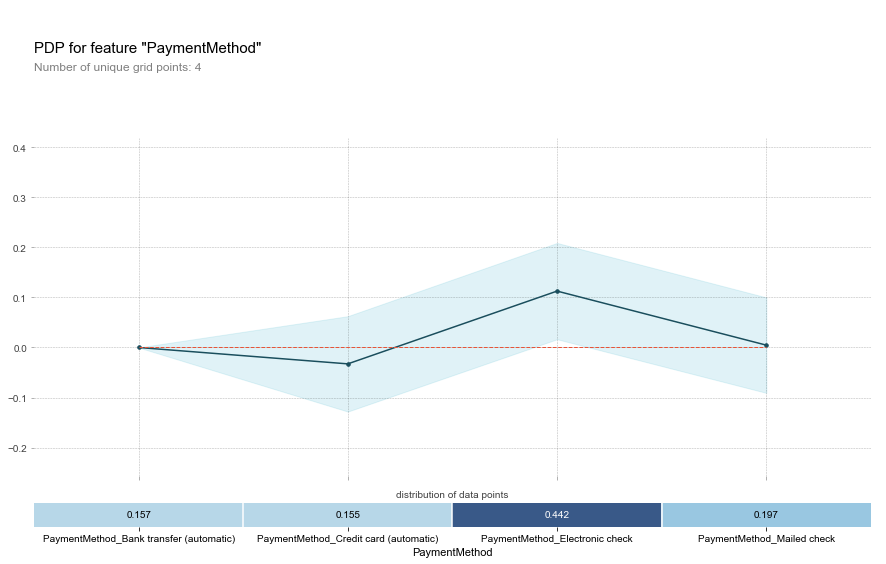

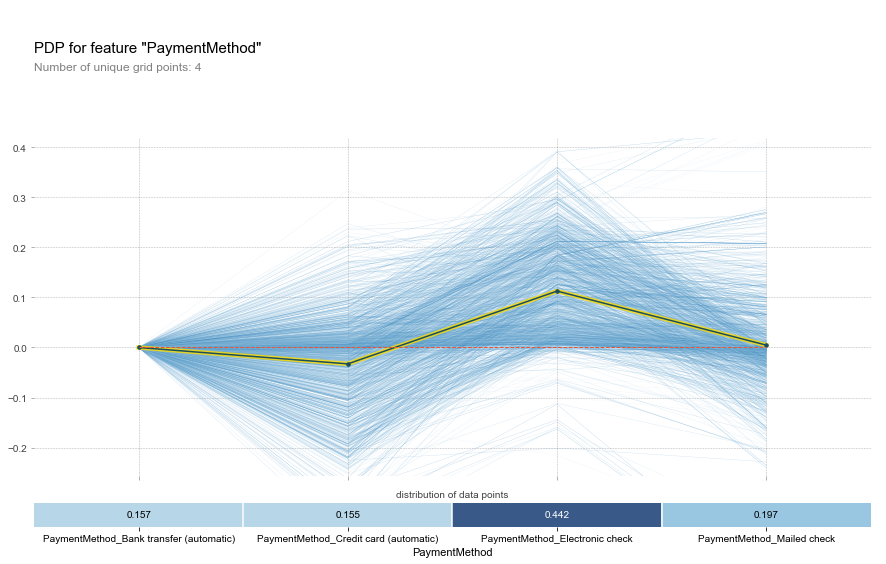

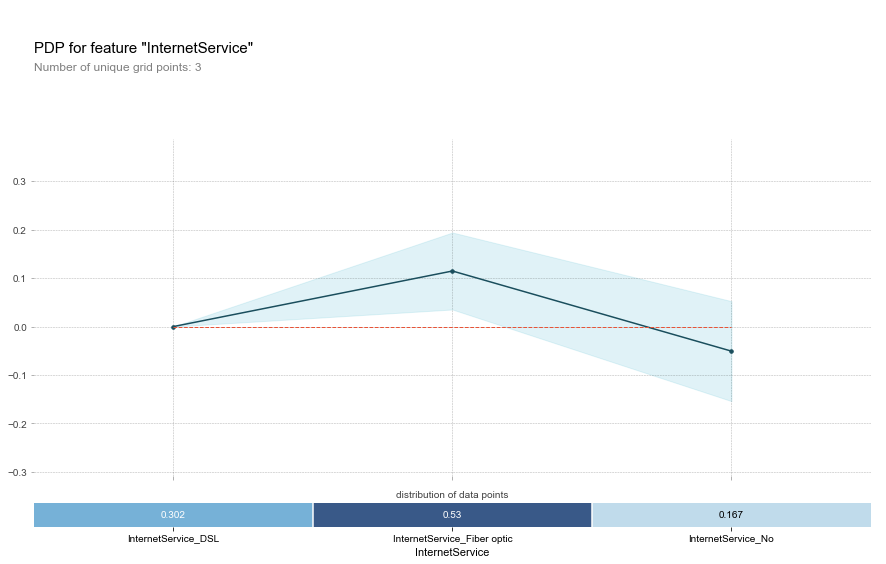

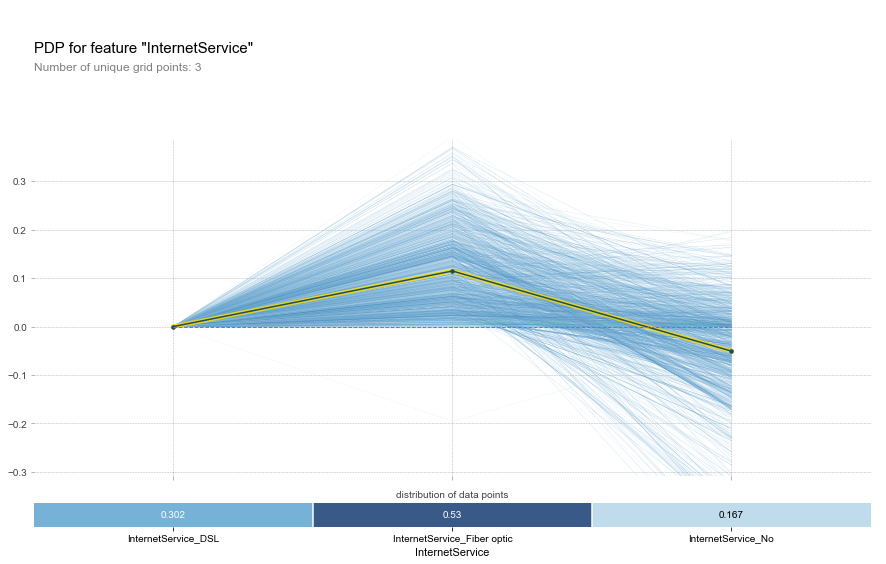

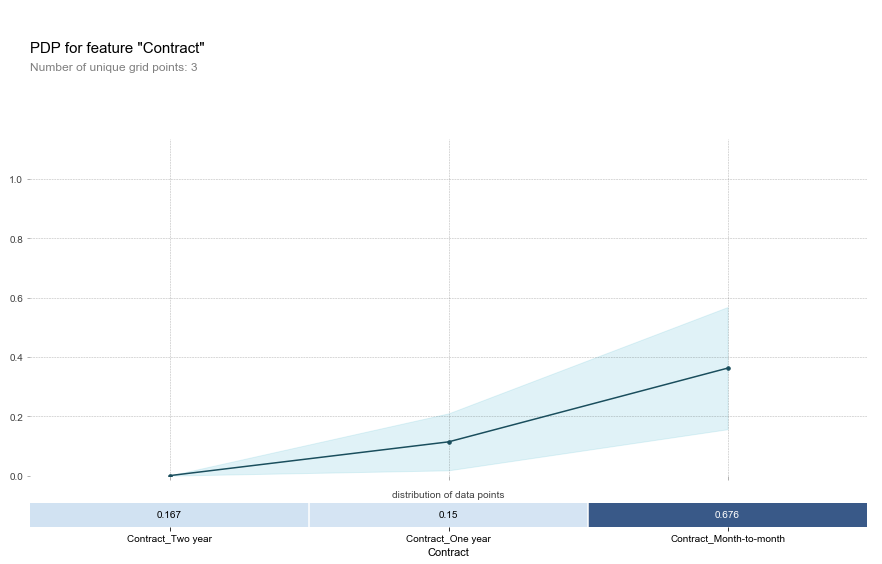

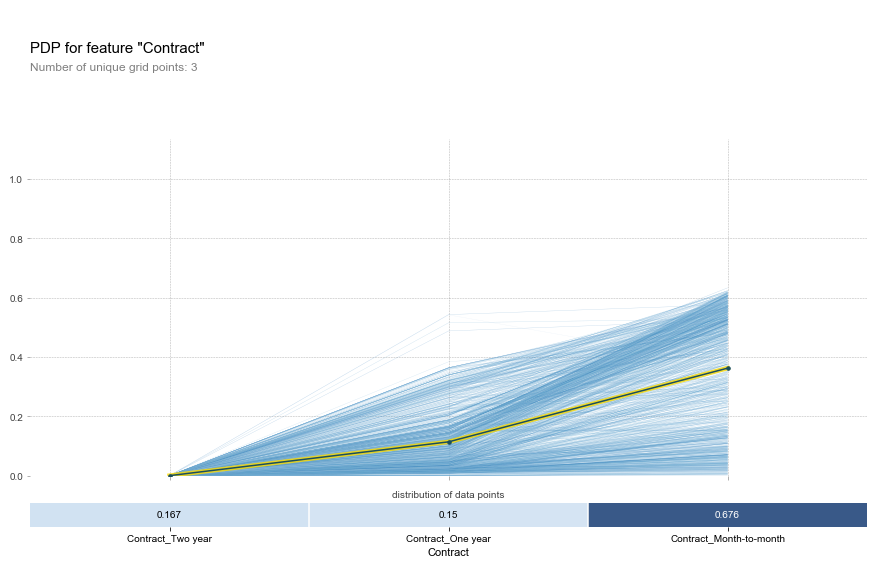

In [38]:

### Multiple categorical variables

## For PaymentMethod  
pdp_PaymentMethod = pdp.pdp_isolate( model2, dataset=X_train2,  model_features= features, feature=[ 'PaymentMethod_Bank transfer (automatic)','PaymentMethod_Credit card (automatic)','PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'], num_grid_points=2)
fig, axes = pdp.pdp_plot(pdp_PaymentMethod, 'PaymentMethod' ,plot_pts_dist=True)
# Variant 
fig, axes = pdp.pdp_plot(pdp_PaymentMethod, 'PaymentMethod', center=True, plot_lines=True, frac_to_plot=0.2, plot_pts_dist=True)
# Interesting result only for this variable. Suggests that only Electronic Payment is truly important, credit card in a smaller extent.
# We could keep solely these two dummies and eliminate the others. This is deduced using this plot + PDP/ICE analysis of dummies, made above. 

## For InternetService - multiple categorical variable 
pdp_InternetService = pdp.pdp_isolate( model2, dataset=X_train2,  model_features= features, feature=['InternetService_DSL','InternetService_Fiber optic', 'InternetService_No'], num_grid_points=2)
fig, axes = pdp.pdp_plot(pdp_InternetService, 'InternetService' ,plot_pts_dist=True)
# Variant 
fig, axes = pdp.pdp_plot(pdp_InternetService, 'InternetService', center=True, plot_lines=True, frac_to_plot=0.2, plot_pts_dist=True)

## For Contract - multiple categorical variable 
pdp_Contract = pdp.pdp_isolate( model2, dataset=X_train2,  model_features= features, feature=['Contract_Two year', 'Contract_One year', 'Contract_Month-to-month'], num_grid_points=2)
fig, axes = pdp.pdp_plot(pdp_Contract, 'Contract' ,plot_pts_dist=True)
# Variant 
fig, axes = pdp.pdp_plot(pdp_Contract, 'Contract', center=True, plot_lines=True, frac_to_plot=0.2, plot_pts_dist=True)

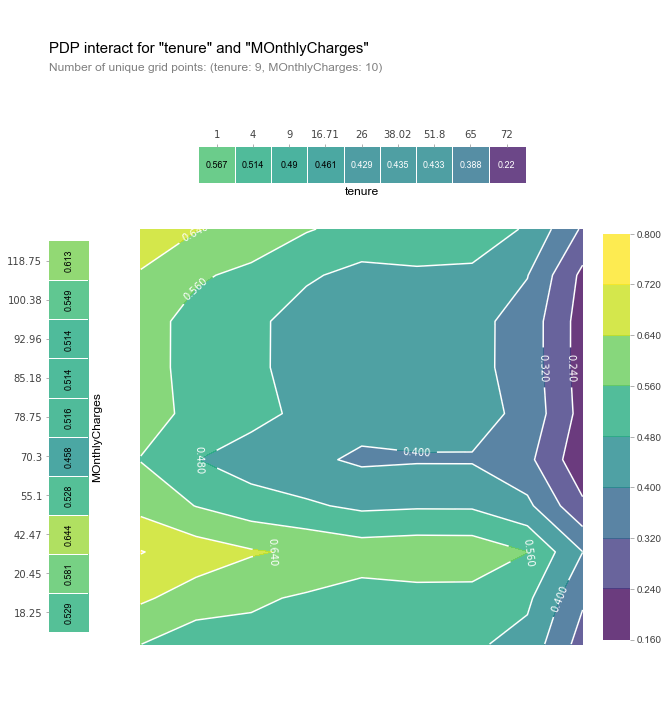

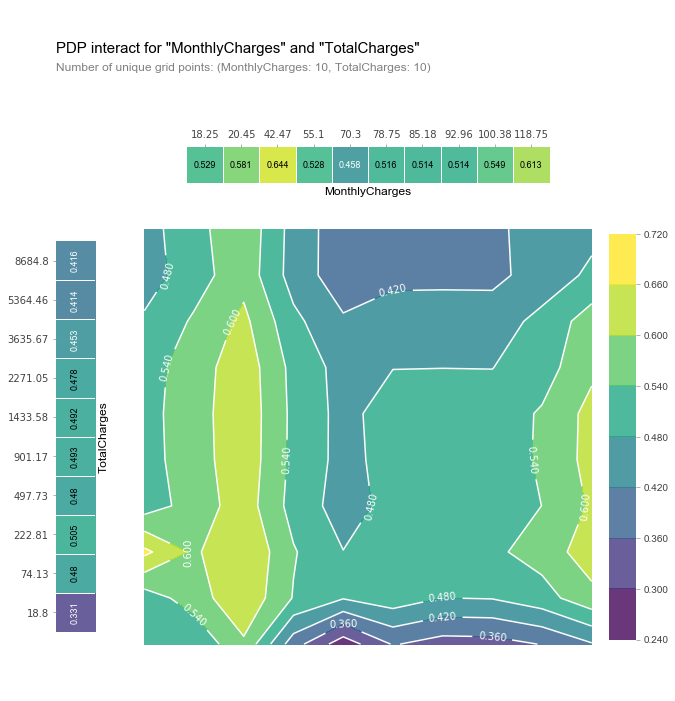

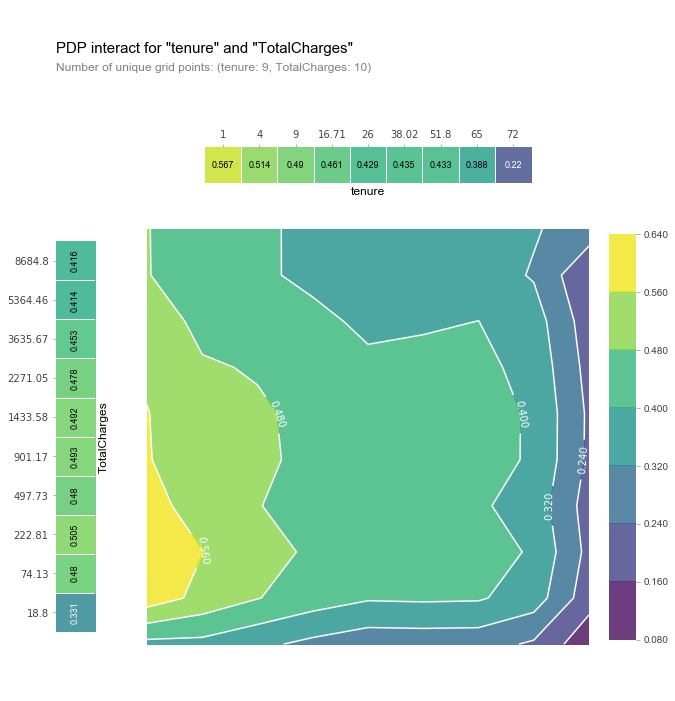

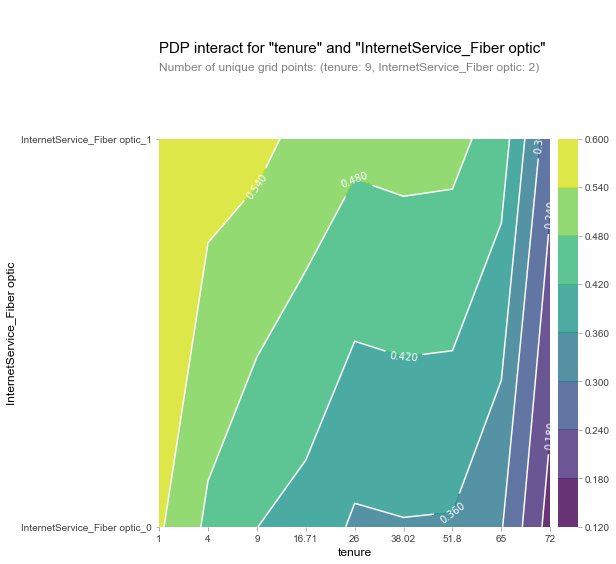

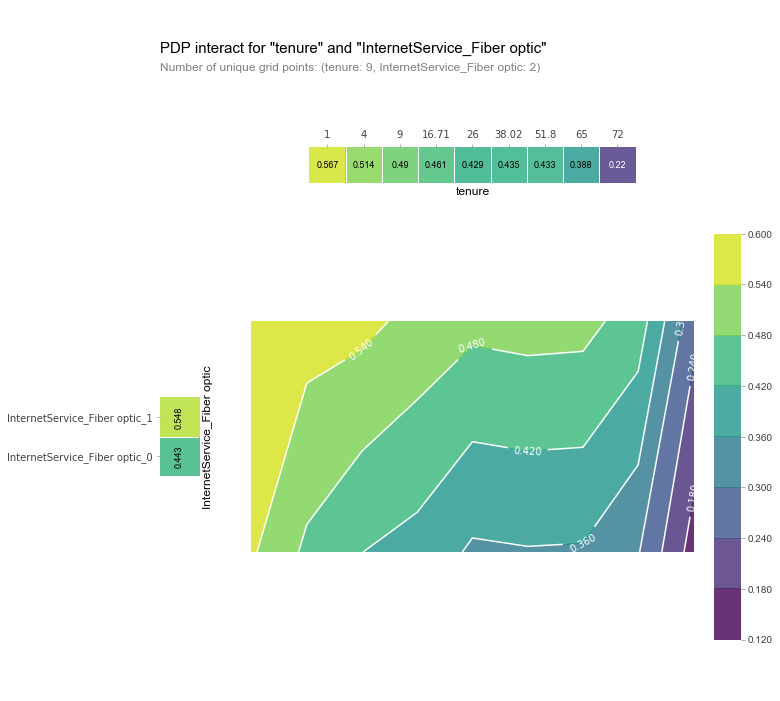

In [39]:

### 2 dimensional PDP. 

# Capture interaction between two variables - especially useful for continuous ones
inter1 = pdp.pdp_interact(model2, dataset=X_train2,  model_features= features, features=['tenure', 'MonthlyCharges'])
fig, axes = pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=['tenure','MOnthlyCharges'], plot_type='contour', x_quantile=True, plot_pdp=True)

inter2 = pdp.pdp_interact(model2, dataset=X_train2,  model_features= features, features=['MonthlyCharges', 'TotalCharges'])
fig, axes = pdp.pdp_interact_plot(pdp_interact_out=inter2, feature_names=['MonthlyCharges','TotalCharges'], plot_type='contour', x_quantile=True, plot_pdp=True)

inter3 = pdp.pdp_interact(model2, dataset=X_train2,  model_features= features, features=['tenure', 'TotalCharges'])
fig, axes = pdp.pdp_interact_plot(pdp_interact_out=inter3, feature_names=['tenure','TotalCharges'], plot_type='contour', x_quantile=True, plot_pdp=True)


inter2 = pdp.pdp_interact(model2, dataset=X_train2,  model_features= features, features=['tenure', 'InternetService_Fiber optic'])
fig, axes = pdp.pdp_interact_plot(pdp_interact_out=inter2, feature_names=['tenure', 'InternetService_Fiber optic'], plot_type='contour', x_quantile=True)
fig, axes = pdp.pdp_interact_plot(pdp_interact_out=inter2, feature_names=['tenure', 'InternetService_Fiber optic'], plot_type='contour', x_quantile=True, plot_pdp=True)